# Imports

In [3]:
import sys

CODE_DIR = "/home/cbarkhof/fall-2021"
BDA_MODEL_DIR = "/home/cbarkhof/fall-2021/analysis/bda_models"

sys.path.append(CODE_DIR)
sys.path.append(BDA_MODEL_DIR)

In [4]:
%config InlineBackend.figure_format='retina'
%matplotlib inline

import numpy as np
import numpyro

import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import arviz as az

from tabulate import tabulate
import numpy as np
from collections import OrderedDict
from itertools import cycle

import os
import torch
import pandas as pd

from transformers import RobertaTokenizerFast
import torch.distributions as td

from bda_dp_mixture_surprisal_vals import *
from bda_sequence_length_model_ptb import *

from analysis_run_postprocessing.general_postprocessing_steps import make_run_overview_df

Running on NumPryo v0.8.0


In [5]:
SAVE_DIR = "output_files"

SAVE_BDA_SURPRISAL_VALS_FILE = f"{SAVE_DIR}/sequence_len_surprisal_values.pt"

SAVE_SURPRISAL_DP_FILE = f"{SAVE_DIR}/sequence_length_surprisal_dp_mixtures.pt"

SAVE_DP_COMP_KL_DISTS_FILE = f"{SAVE_DIR}/sequence_length_dp_mixtures_kl_comp_dists.pt"

LENGTH_DATA_FILE = "ptb_length_analysis_data.pt"

os.makedirs(SAVE_DIR, exist_ok=True)

In [6]:
PLOT_LENGHTS = False

FIT_AND_COMPUTE_SURPRISAL_VALS = False

PERFORM_MODEL_CHECKS = False

FIT_SURPRISAL_DPS = False

# Load overview of relevant PTB runs

In [7]:
overview_df = pd.read_csv("/home/cbarkhof/fall-2021/analysis/final_selection_runs.csv", index_col=0)
overview_df = overview_df[overview_df.image_or_language == "language"]

global_stats_df = pd.read_csv("/home/cbarkhof/fall-2021/analysis/global_stats.csv", index_col=0)
global_stats_df = global_stats_df[(global_stats_df.index.isin(overview_df.index)) \
                                  & (global_stats_df.phase == "valid")]

overview_df.head()

objective  l_rate dataset  \
INFO-VAE l_Rate 0.1 l_MMD 1 dec: Strong roBERTa    INFO-VAE     0.1     ptb   
INFO-VAE l_Rate 0.1 l_MMD 10 dec: Strong roBERTa   INFO-VAE     0.1     ptb   
INFO-VAE l_Rate 0.1 l_MMD 100 dec: Strong roBERTa  INFO-VAE     0.1     ptb   
INFO-VAE l_Rate 0.5 l_MMD 1 dec: Strong roBERTa    INFO-VAE     0.5     ptb   
INFO-VAE l_Rate 0.5 l_MMD 10 dec: Strong roBERTa   INFO-VAE     0.5     ptb   

                                                  image_or_language  \
INFO-VAE l_Rate 0.1 l_MMD 1 dec: Strong roBERTa            language   
INFO-VAE l_Rate 0.1 l_MMD 10 dec: Strong roBERTa           language   
INFO-VAE l_Rate 0.1 l_MMD 100 dec: Strong roBERTa          language   
INFO-VAE l_Rate 0.5 l_MMD 1 dec: Strong roBERTa            language   
INFO-VAE l_Rate 0.5 l_MMD 10 dec: Strong roBERTa           language   

                                                   beta_beta  free_bits  \
INFO-VAE l_Rate 0.1 l_MMD 1 dec: Strong roBERTa          0.0          0   
INFO-VAE l_Rate 0.1 l_MMD 10 dec: Strong roBERTa         0.0          0   
INFO-VAE l_Rate 0.1 l_MMD 100 dec: Strong roBERTa        0.0          0   
INFO-VAE l_Rate 0.5 l_MMD 1 dec: Strong roBERTa          0.0          0   
INFO-VAE l_Rate 0.5 l_MMD 10 dec: Strong roBERTa         0.0          0   

                                                   mdr_value  l_mmd  \
INFO-VAE l_Rate 0.1 l_MMD 1 dec: Strong roBERTa            0      1   
INFO-VAE l_Rate 0.1 l_MMD 10 dec: Strong roBERTa           0     10   
INFO-VAE l_Rate 0.1 l_MMD 100 dec: Strong roBERTa          0    100   
INFO-VAE l_Rate 0.5 l_MMD 1 dec: Strong roBERTa            0      1   
INFO-VAE l_Rate 0.5 l_MMD 10 dec: Strong roBERTa           0     10   

                                                                         decoder  \
INFO-VAE l_Rate 0.1 l_MMD 1 dec: Strong roBERTa    strong_distil_roberta_decoder   
INFO-VAE l_Rate 0.1 l_MMD 10 dec: Strong roBERTa   strong_distil_roberta_decoder   
INFO-VAE l_Rate 0.1 l_MMD 100 dec: Strong roBERTa  strong_distil_roberta_decoder   
INFO-VAE l_Rate 0.5 l_MMD 1 dec: Strong roBERTa    strong_distil_roberta_decoder   
INFO-VAE l_Rate 0.5 l_MMD 10 dec: Strong roBERTa   strong_distil_roberta_decoder   

                                                                                            run_name  
INFO-VAE l_Rate 0.1 l_MMD 1 dec: Strong roBERTa    (5-jan ptb-test) INFO-VAE[l_1_rate=0.1, l_2_mm...  
INFO-VAE l_Rate 0.1 l_MMD 10 dec: Strong roBERTa   (5-jan ptb-test) INFO-VAE[l_1_rate=0.1, l_2_mm...  
INFO-VAE l_Rate 0.1 l_MMD 100 dec: Strong roBERTa  (5-jan ptb-test) INFO-VAE[l_1_rate=0.1, l_2_mm...  
INFO-VAE l_Rate 0.5 l_MMD 1 dec: Strong roBERTa    (11-jan ptb) INFO-VAE[l_1_rate=0.5, l_2_mmd=1....  
INFO-VAE l_Rate 0.5 l_MMD 10 dec: Strong roBERTa   (11-jan ptb) INFO-VAE[l_1_rate=0.5, l_2_mmd=10...

# Load lengths data and model groups

`ptb_lengths` has key-value structure:
- `data_group`:
    - `train `
    - `valid`
- `modelgroups`:
    - `<run_name>`

In [8]:
if PLOT_LENGHTS or FIT_AND_COMPUTE_SURPRISAL_VALS:
    if os.path.exists(LENGTH_DATA_FILE):
        ptb_lengths = torch.load(LENGTH_DATA_FILE)

        for i in range(len(list(ptb_lengths["model_groups"].values()))):
            for k, v in list(ptb_lengths["model_groups"].values())[i].items():
                print(i, k, len(v))

        for k, v in ptb_lengths["data_group"].items():
            print(k, len(v))
    else:
        print(f"LENGTH_DATA_FILE={LENGTH_DATA_FILE} not found, run preprocess NB first.")

# Plot
data group - conditional model samples - unconditional model samples

In [9]:
if PLOT_LENGHTS:
    ncols = 3

    dataset_name = "PTB"
    dictionary = ptb_lengths
    train_data = dictionary["data_group"]["train"]
    valid_data = dictionary["data_group"]["valid"]

    hist_kwargs = dict(density=True, bins=62, lw=0)

    for i, (model_name, con_uncon_dict) in enumerate(dictionary["model_groups"].items()):
        
        
        print(model_name)
        fig, axs = plt.subplots(ncols=ncols, figsize=(ncols*4, 3))
        axs[0].hist(train_data, label="train", color="red", alpha=0.4, **hist_kwargs)
        axs[0].hist(valid_data, label="valid", color="pink", alpha=0.4,  **hist_kwargs)
        axs[0].axvline(np.mean(train_data), color='red')
        axs[0].axvline(np.mean(valid_data), color='pink')
        title = f"Data group ({dataset_name.upper()})"
        title += "\n" + f"min len: {min(train_data + valid_data)} max len: {max(train_data + valid_data)}"
        axs[0].set_title(title, size=8, y=1.02)

        col = 1
        for j, (k, lengths) in enumerate(con_uncon_dict.items()):
            if k == "condition":
                continue
            axs[col].hist(lengths, color="royalblue", **hist_kwargs)
            axs[col].axvline(np.mean(lengths), color='royalblue')
            min_len = min(lengths)
            max_len = max(lengths)
            #print(min_len, max_len)
            title = k + "\n" + f"min len: {min_len} max len: {max_len}"
            axs[col].set_title(title, size=8, y=1.02)
            axs[col].set_ylim([0, 0.06])
            axs[col].set_xlim([0, 63])

            col += 1

        plt.suptitle(model_name)
        plt.tight_layout()
        plt.show()

# Conditional sample length versus length conditional

In [10]:
if PLOT_LENGHTS:
    dataset_dict = ptb_lengths
    validation_data = dataset_dict["data_group"]["valid"]

    for model_group, d in ptb_lengths["model_groups"].items():
        print(model_group)
        fig, ax = plt.subplots(figsize=(3, 3))

        model_conditional_validation = d["conditional_sample"][:len(validation_data)]

        ax.scatter(validation_data, model_conditional_validation, alpha=0.1, color="royalblue")
        ax.set_xlabel("data lenght")
        ax.set_ylabel("sampled length")
        ax.set_title(model_group, size=8)
        ax.set_xlim([0, 63])
        ax.set_ylim([0, 63])

        plt.show()

# Fit length model

In [11]:
if FIT_AND_COMPUTE_SURPRISAL_VALS:

    NUM_CHAINS = 1
    NUM_WARMUP = 500
    NUM_SAMPLES = 2000

    # Concat the validation (3370) and the train data (both N = 2000)
    ptb_data = ptb_lengths["data_group"]["valid"] + ptb_lengths["data_group"]["train"]
    type(ptb_data), len(ptb_data), len(ptb_lengths["data_group"]["valid"]), len(ptb_lengths["data_group"]["train"])

    print("Num train + valid samples", len(ptb_data))

    model = GenSeqLenModelPTB(
        ["ptb_train_valid_data"],
        [ptb_data],
        N_valid=len(ptb_lengths["data_group"]["valid"]),
        gamma_shape=[10., 1.9], 
        num_comps=5,
        DP_alpha=0.1, 
        num_chains=NUM_CHAINS, 
        num_warmup=NUM_WARMUP, 
        num_samples=NUM_SAMPLES)
    
    if PERFORM_MODEL_CHECKS:
        print("-"*80)
        print("PRIOR CHECKS")
        prior_samples = model.draw_prior_predictions()
        print(tabulate([(k, v.shape) for k, v in prior_samples.items()], headers=['rv', 'shape']))
        _ = plot_predictions(model, prior_samples['y'], sharex='row', bins=[30, 30])
        _ = plot_checks(model, prior_samples['y'])
    
    model.run()
    
    if PERFORM_MODEL_CHECKS:
        print("-"*80)
        print("POSTERIOR CHECKS")
        posterior_samples = model.draw_posterior_predictions()
        print(tabulate([(k, v.shape) for k, v in posterior_samples.items()], headers=['rv', 'shape']))
        _ = plot_predictions(model, posterior_samples['y'], bins=[50, 50], sharex='row', sharey='row')
        _ = plot_checks(model, posterior_samples['y'])


# Compute surprisal values

In [12]:
if FIT_AND_COMPUTE_SURPRISAL_VALS:
    surprisal_values = dict()

    local_samples = model.infer_local_assignments(model.posterior_samples, model.y)
    print(tabulate([(k, v.shape) for k, v in local_samples.items()], headers=['rv', 'shape']))

    for i, (model_name, con_uncon_dict) in enumerate(ptb_lengths["model_groups"].items()):
        print(i, model_name)

        conditional_lengths = con_uncon_dict["conditional_sample"]

        unconditional_length = con_uncon_dict["sample"]

        # Estimate log_p_x_y
        cond_cond = - model.estimate_log_p_x_conditional(conditional_lengths, local_samples=local_samples)

        # Estimate log_p_x (returns a numpy array)
        uncond_uncond = - model.estimate_log_p_x(unconditional_length, posterior_samples=posterior_samples)

        # Estimate log_p_x (returns a numpy array)
        uncond_cond = - model.estimate_log_p_x(conditional_lengths, posterior_samples=posterior_samples)

        surprisal_values[model_name] = dict(
            conditional_conditional=cond_cond, 
            unconditional_unconditional=uncond_uncond,
            unconditional_conditional=uncond_cond
        )

    surprisal_values["data_group"] = {
        "unconditional_unconditional": - model.estimate_log_p_x(ptb_lengths["data_group"]["valid"], posterior_samples=posterior_samples),
        "conditional_conditional": - model.estimate_log_p_x_conditional(ptb_lengths["data_group"]["valid"], local_samples=local_samples)
    }
    surprisal_values["data_group"]["unconditional_conditional"] = surprisal_values["data_group"]["unconditional_unconditional"]

    torch.save(surprisal_values, SAVE_BDA_SURPRISAL_VALS_FILE)

else:
    if os.path.exists(SAVE_BDA_SURPRISAL_VALS_FILE):
        surprisal_values = torch.load(SAVE_BDA_SURPRISAL_VALS_FILE)
    else:
        print(f"SAVE_BDA_SURPRISAL_VALS_FILE={SAVE_BDA_SURPRISAL_VALS_FILE} not found," 
              "run NB with FIT_AND_COMPUTE_SURPRISAL_VALS=True to compute")


Rows: 22, cols: 3, every: 1, n_groups: 22


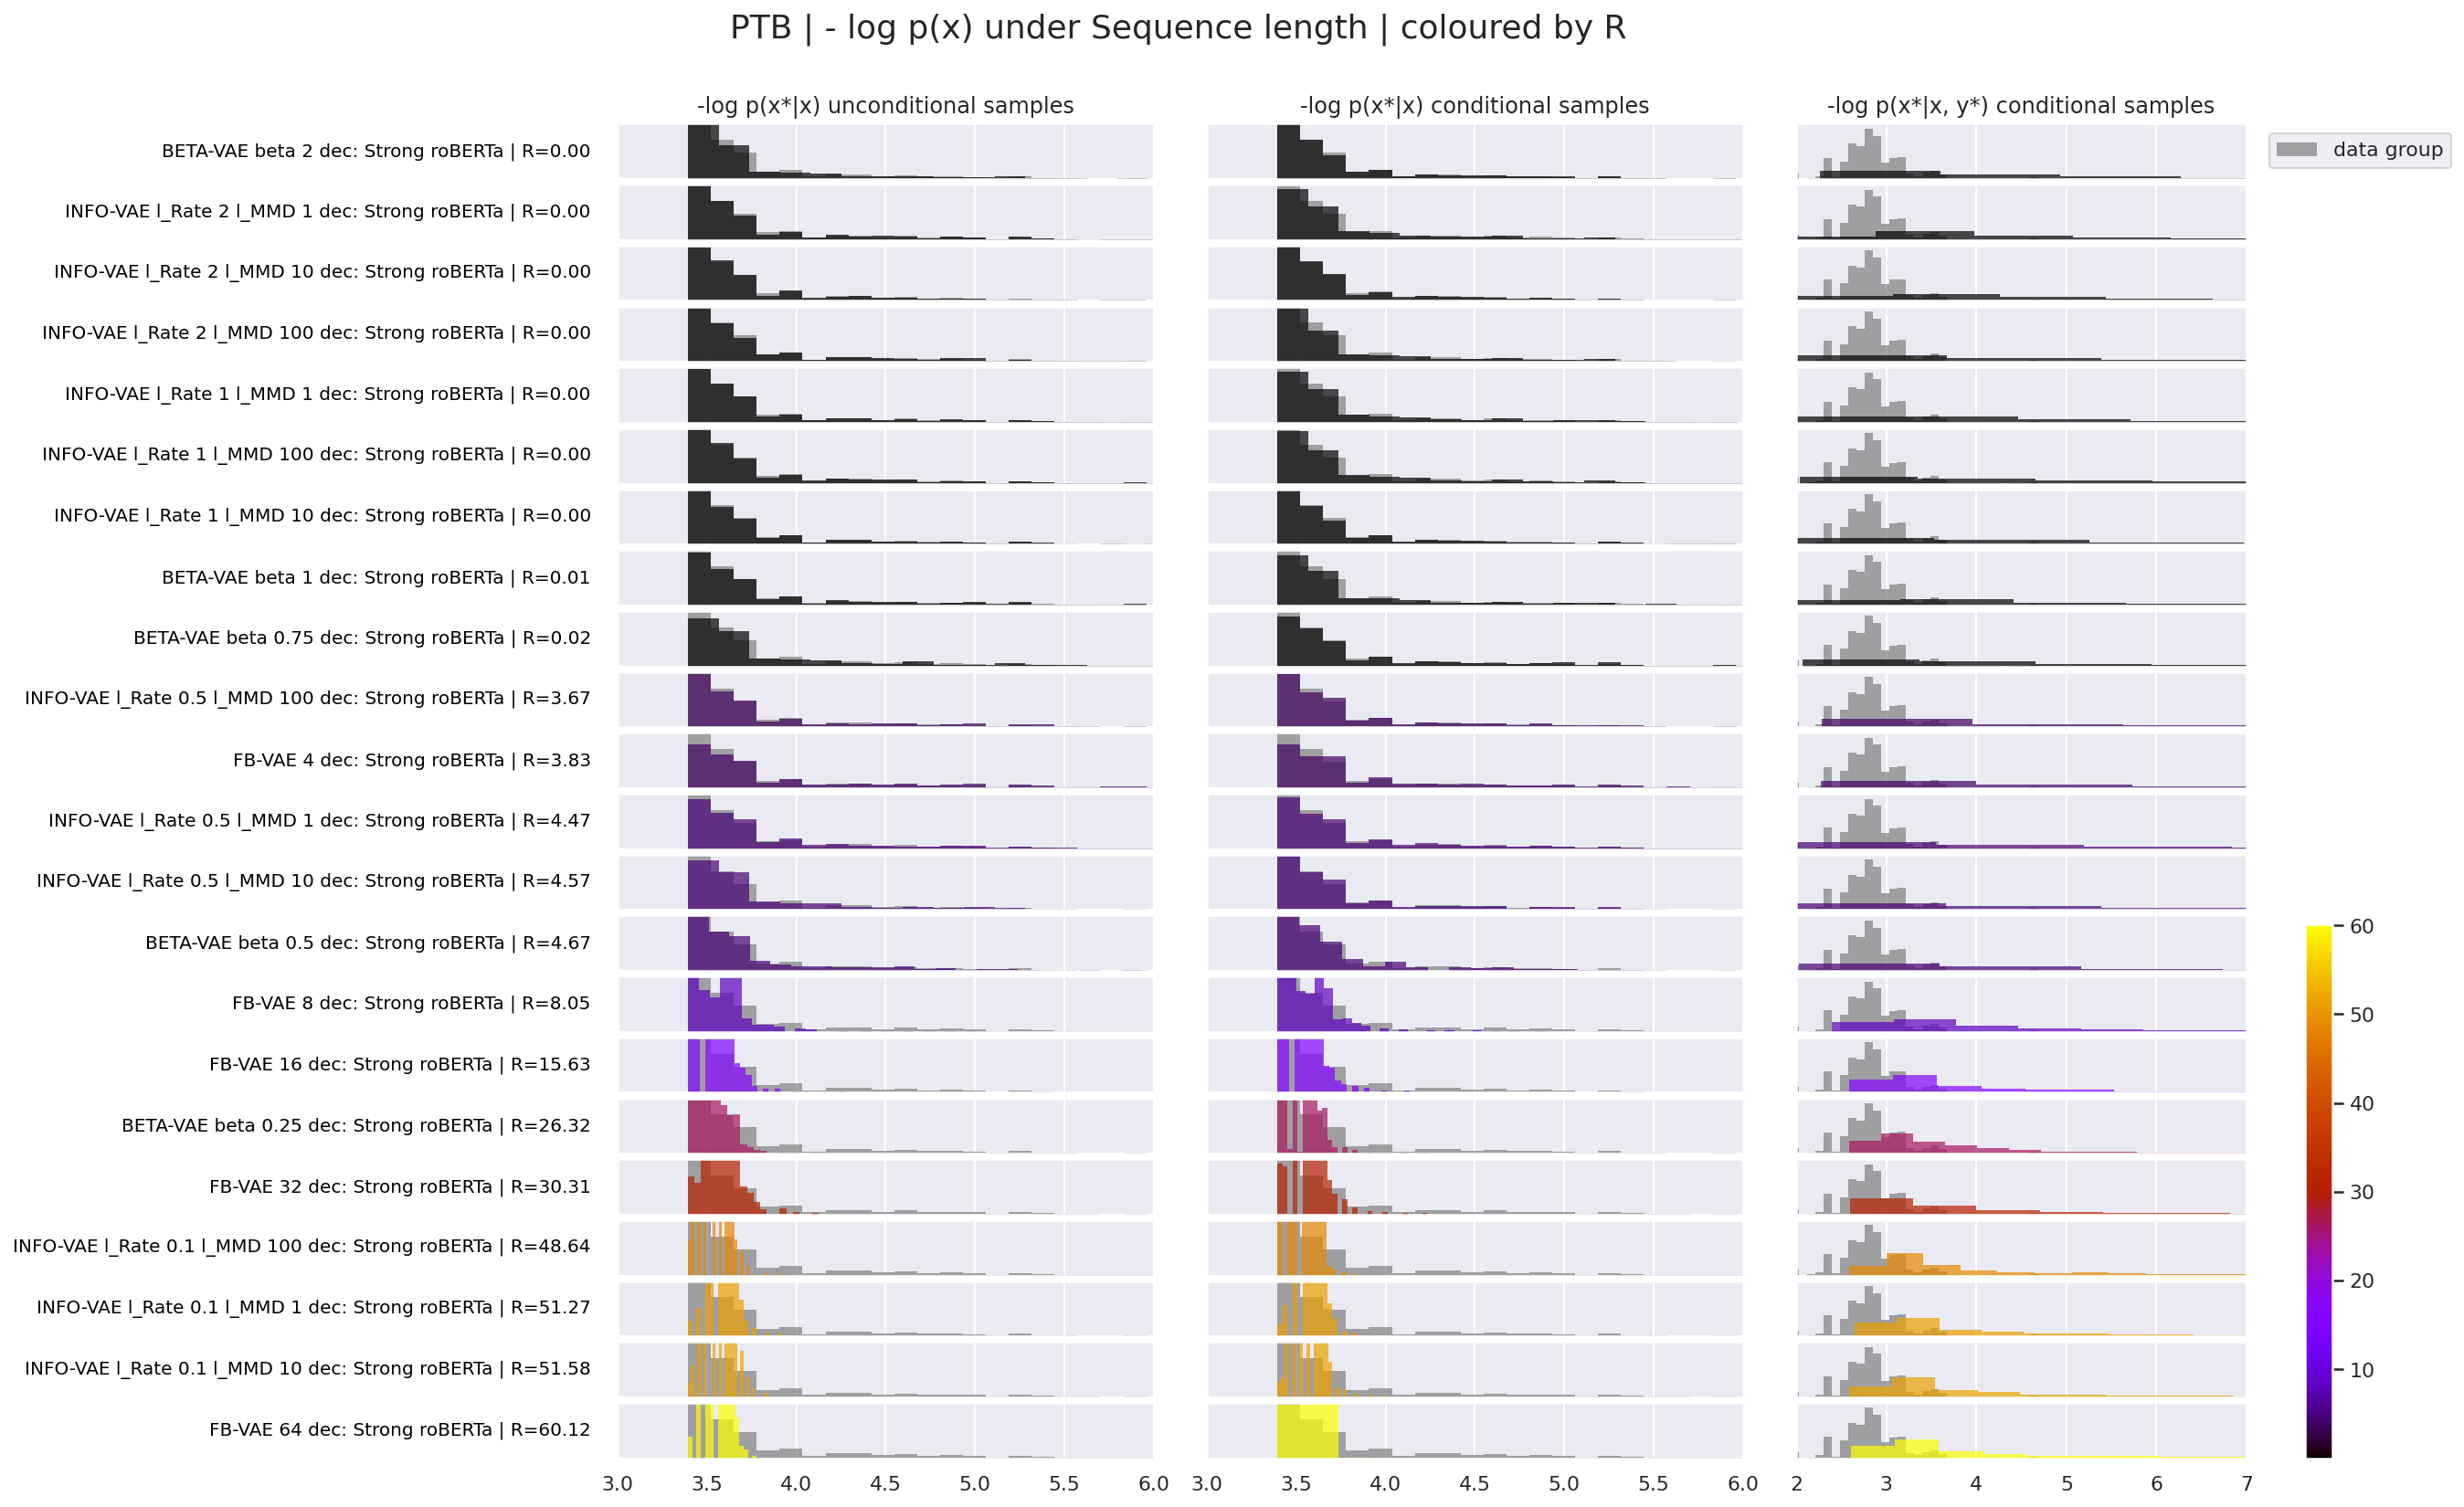

In [16]:
xlims = [[3, 6], [3, 6], [2, 7]]
ylims = [[0, 2.5], [0, 2.5], [0, 2.]]

# Filter our really high rate runs
global_stats_df_filter = global_stats_df[global_stats_df.kl_prior_post < 150]

plot_surprisal_dists_against_global_stat(global_stats_df=global_stats_df_filter, 
                                         surprisal_values=surprisal_values, 
                                         xlims=xlims,
                                         ylims=ylims,
                                         sort_on="kl_prior_post", 
                                         dataset_name="PTB",
                                         latent_structure="Sequence length",
                                         sort_name="R", 
                                         cm_shrink=0.4,
                                         cm_name="gnuplot",
                                         bins=30,
                                         title_size=18,
                                         title_y=1.04,
                                         subsample_nrows=None, 
                                         sort_ascend=True, 
                                         row_height=0.5)

I0121 13:58:28.584170 22878394375936 utils.py:145] Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
I0121 13:58:28.585321 22878394375936 utils.py:157] NumExpr defaulting to 8 threads.


Rows: 22, cols: 3, every: 1, n_groups: 22


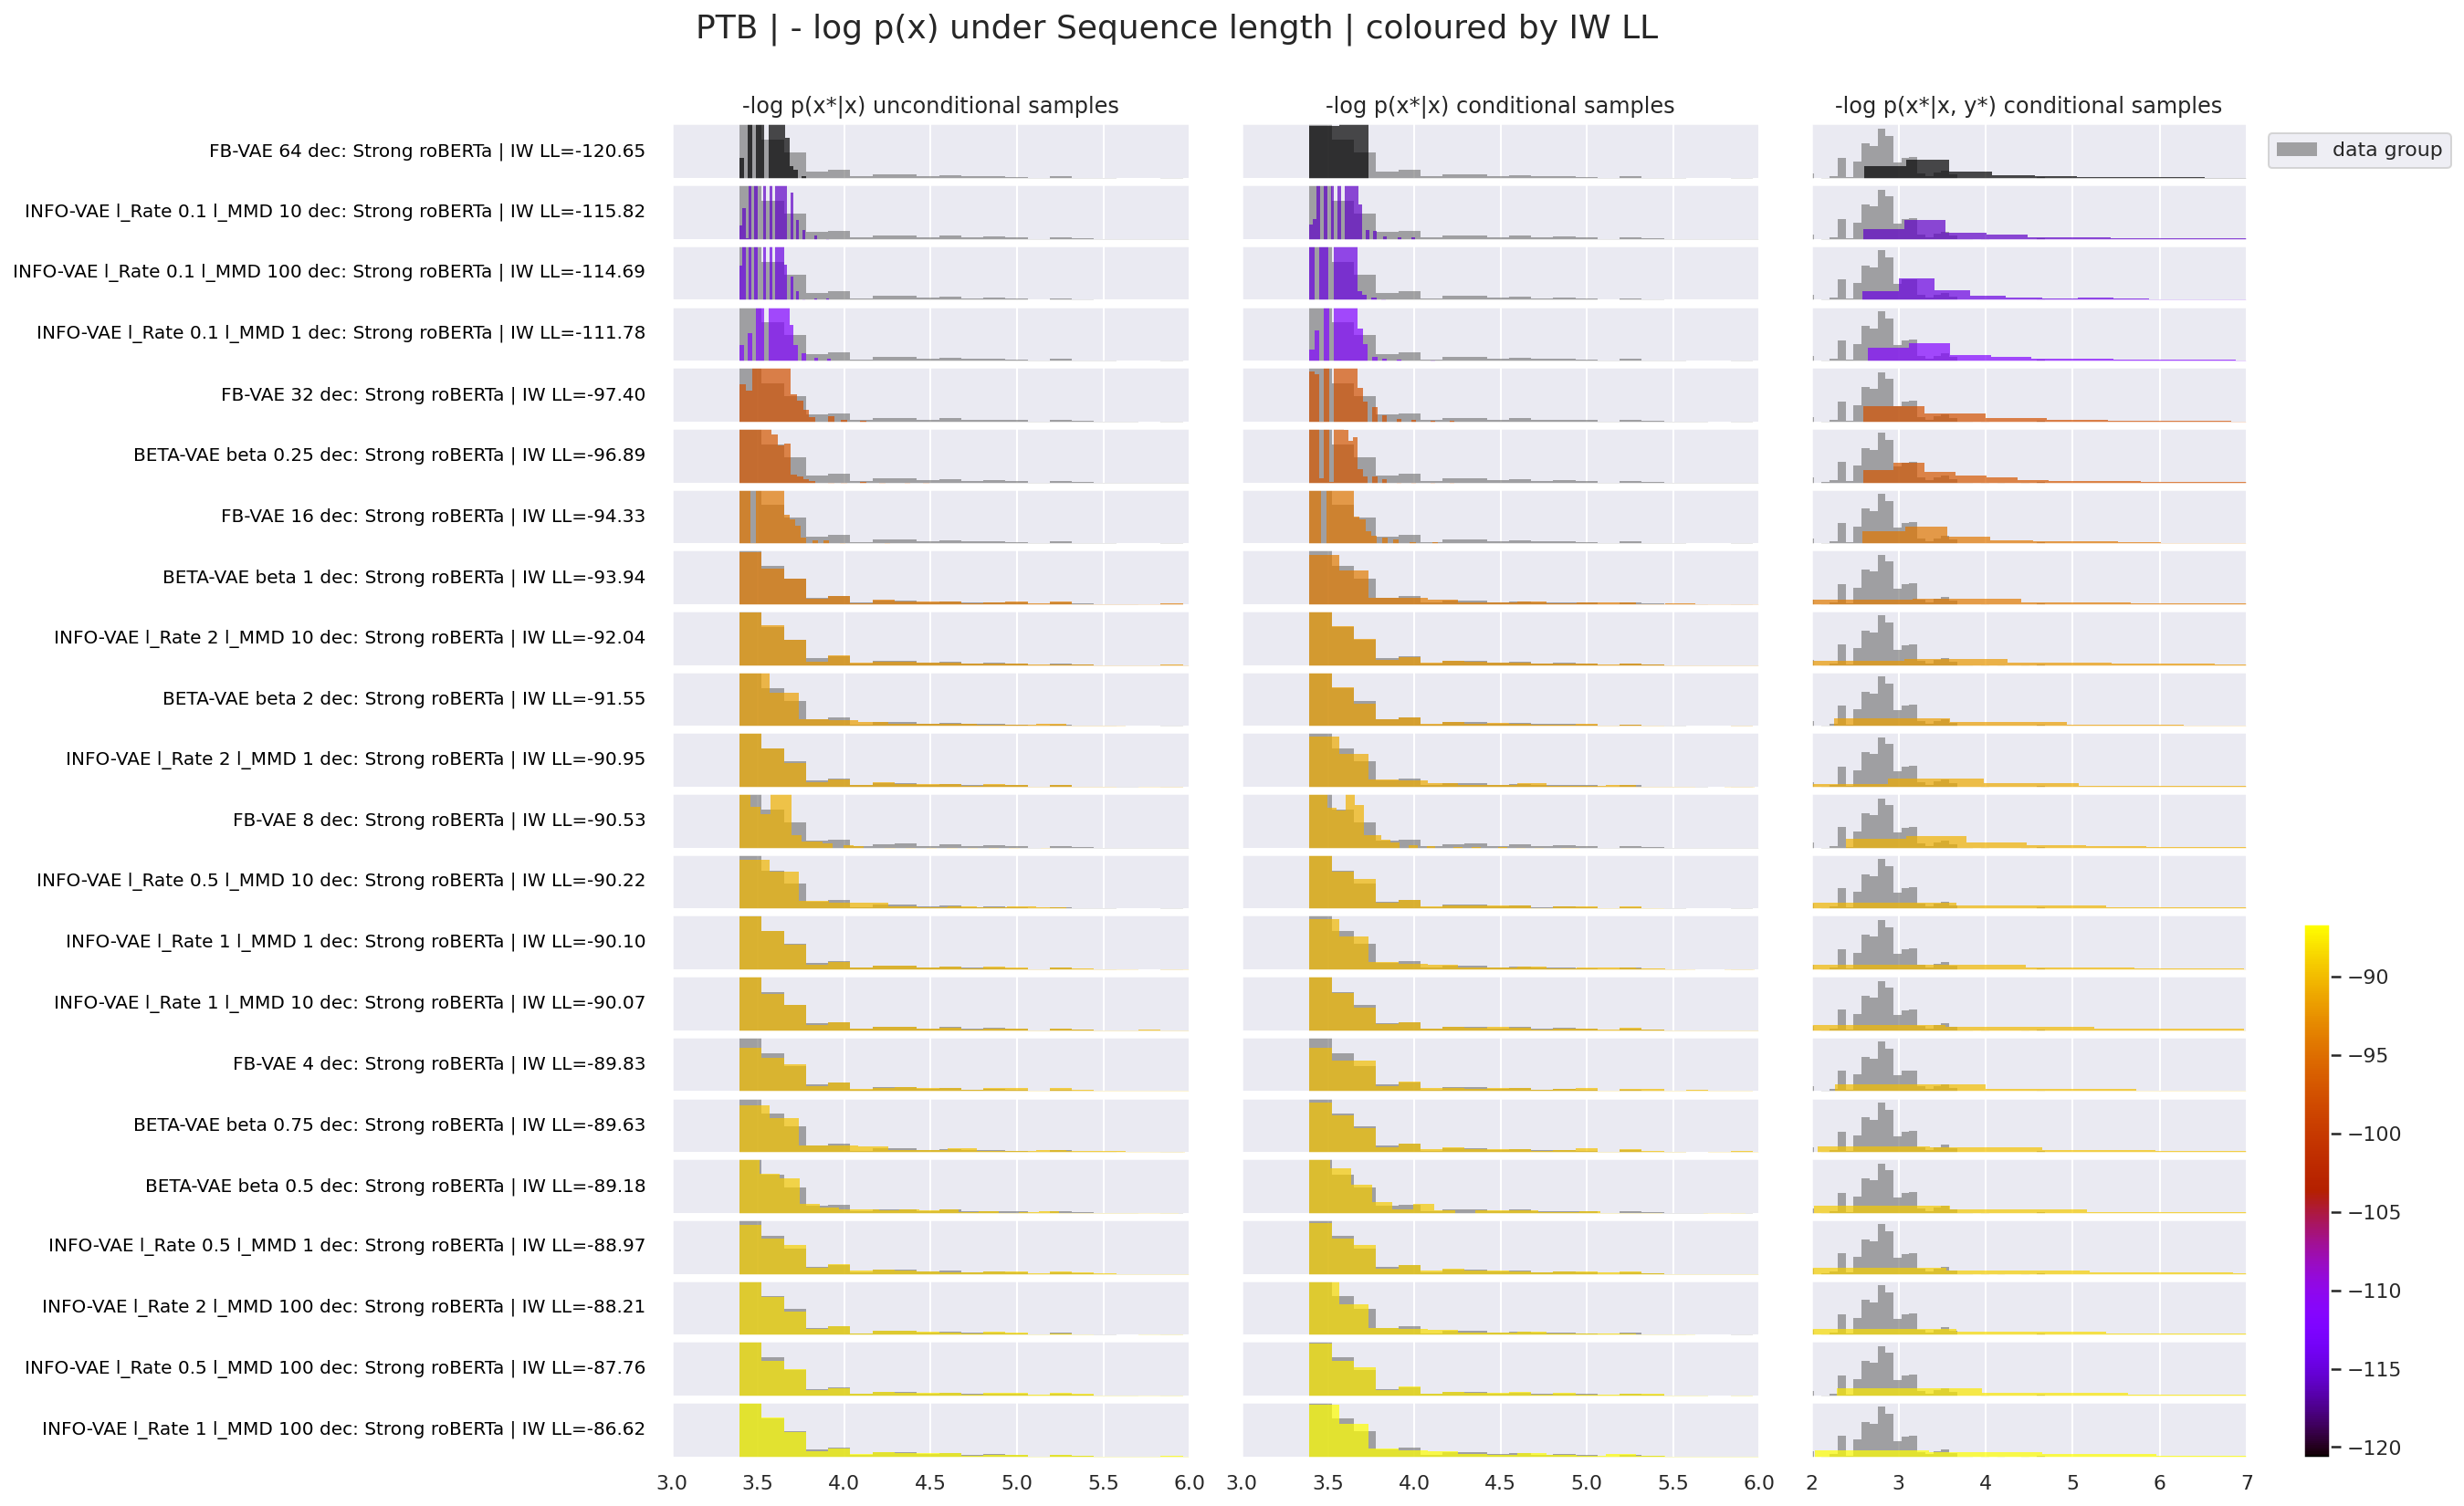

In [13]:
xlims = [[3, 6], [3, 6], [2, 7]]
ylims = [[0, 2.5], [0, 2.5], [0, 2.]]

# Filter our really high rate runs
global_stats_df_filter = global_stats_df[global_stats_df.kl_prior_post < 150]

plot_surprisal_dists_against_global_stat(global_stats_df=global_stats_df_filter, 
                                         surprisal_values=surprisal_values, 
                                         xlims=xlims,
                                         ylims=ylims,
                                         sort_on="IW LL", 
                                         dataset_name="PTB",
                                         latent_structure="Sequence length",
                                         sort_name="IW LL", 
                                         cm_shrink=0.4,
                                         cm_name="gnuplot",
                                         bins=30,
                                         title_size=18,
                                         title_y=1.04,
                                         subsample_nrows=None, 
                                         sort_ascend=True, 
                                         row_height=0.5)

mean y: 3.7723365 std y: 0.57058513 min_y: 3.393774 max y: 8.547491
mean y: 3.76411 std y: 0.5643525 min_y: 3.393774 max y: 7.242527
mean y: 4.8170924 std y: 3.185676 min_y: 1.8832312 max y: 54.11833
Rows: 22, cols: 3, every: 1, n_groups: 22


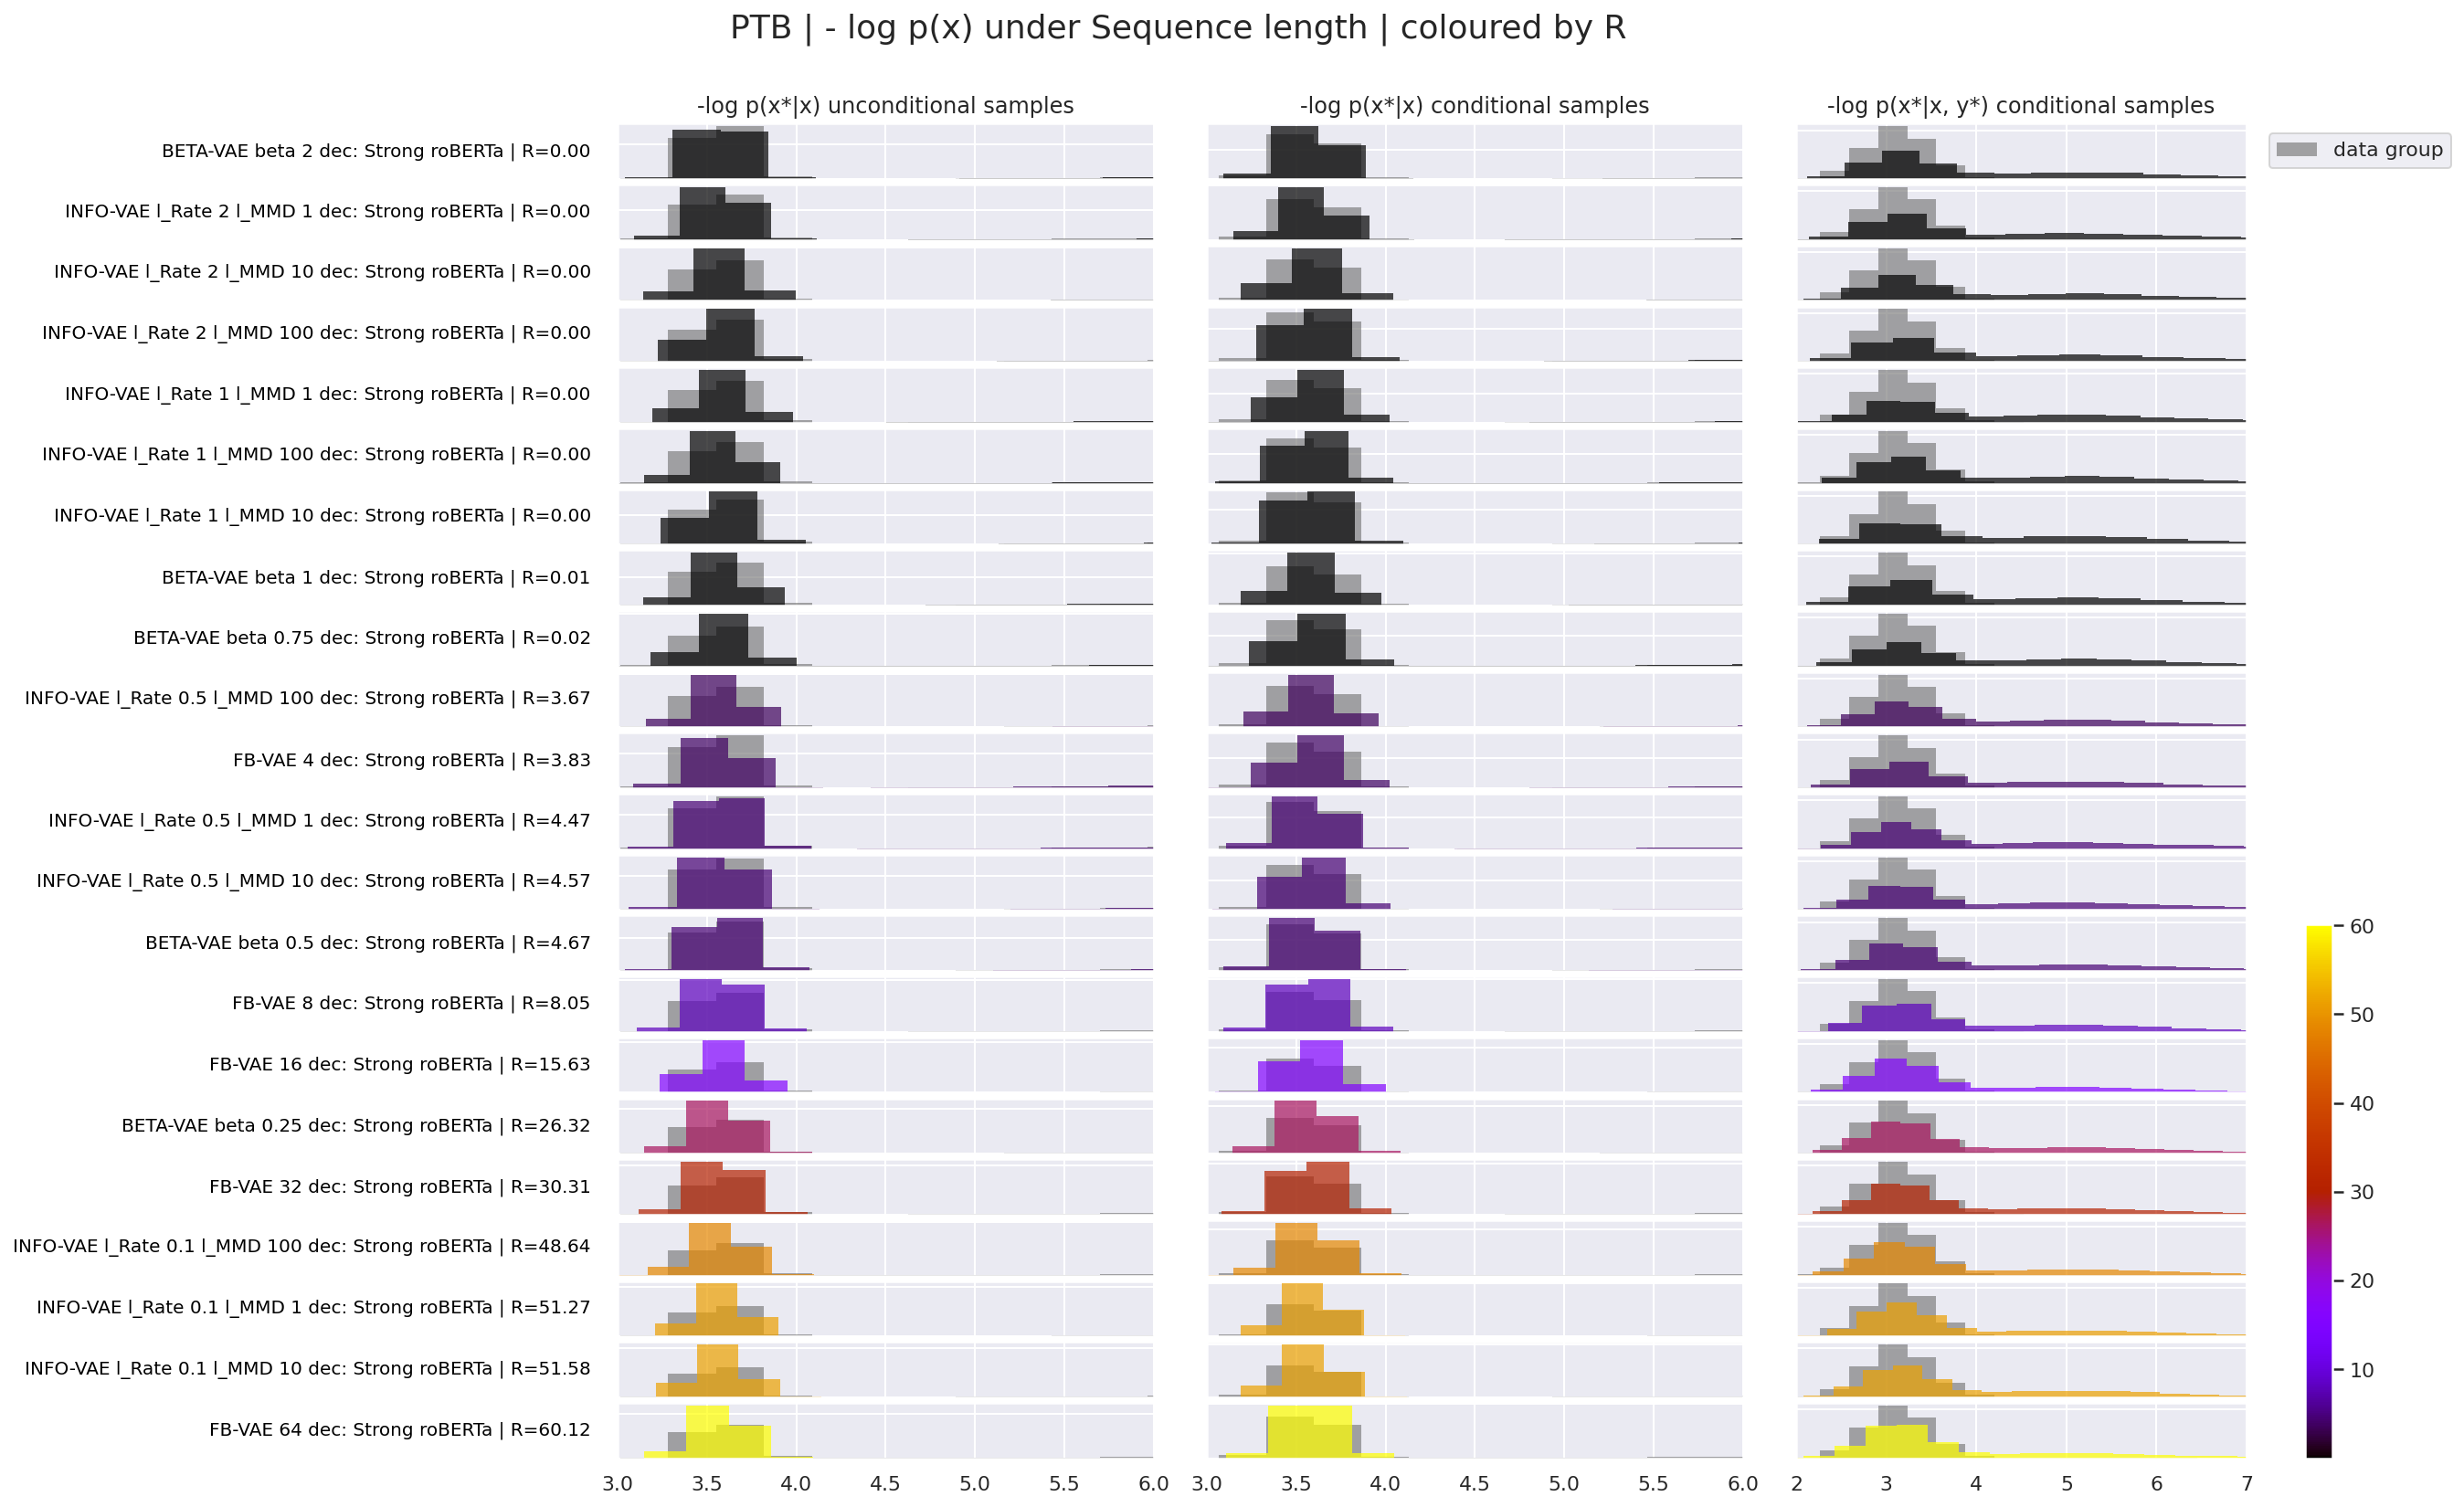

In [17]:
# res_dict = dict()

# for stat_name, dp_mixture in dp_mixtures.items():
    
#     # [N_s, N_x_all]
#     post_y = np.array(dp_mixture.draw_posterior_predictions()["y"])
    
#     for group_idx, group_name in enumerate(dp_mixture.group_names):
#         #print(stat_name, group_idx, group_name)
        
#         if group_name not in res_dict:
#             res_dict[group_name] = dict()
        
#         post_y_g = post_y[:, dp_mixture.obs_g == group_idx].flatten()
#         post_y_g = post_y_g[post_y_g < 10]
        
#         res_dict[group_name][stat_name] = post_y_g
        
# xlims = [[3, 6], [3, 6], [2, 7]]
# # ylims = [[0, 2.5], [0, 2.5], [0, 2.]]
# ylims = [None, None, None]

# # Filter our really high rate runs
# global_stats_df_filter = global_stats_df[global_stats_df.kl_prior_post < 150]

# plot_surprisal_dists_against_global_stat(global_stats_df=global_stats_df_filter, 
#                                          surprisal_values=res_dict, 
#                                          xlims=xlims,
#                                          ylims=ylims,
#                                          sort_on="kl_prior_post", 
#                                          dataset_name="PTB",
#                                          latent_structure="Sequence length",
#                                          sort_name="R", 
#                                          cm_shrink=0.4,
#                                          cm_name="gnuplot",
#                                          bins=30,
#                                          title_size=18,
#                                          title_y=1.04,
#                                          subsample_nrows=None, 
#                                          sort_ascend=True, 
#                                          row_height=0.5)

# Now assess "divergence" from model sample surprisal values from data group in three ways:

1. KL between component assignments under the DP Mixture
2. Difference between estimated densities under the DP Mixture
3. Wasserstein distance between surprisal value histograms (no DP Mixture used)

In [14]:
all_df = compute_all_divergences_data_model_groups(dp_mixtures, surprisal_values, num_components=NUM_COMPS)

UNCONDITIONAL_UNCONDITIONAL
UNCONDITIONAL_CONDITIONAL
CONDITIONAL_CONDITIONAL


In [15]:
all_df_select = all_df[all_df.index.isin(overview_df[overview_df.decoder == "strong_distil_roberta_decoder"].index)]

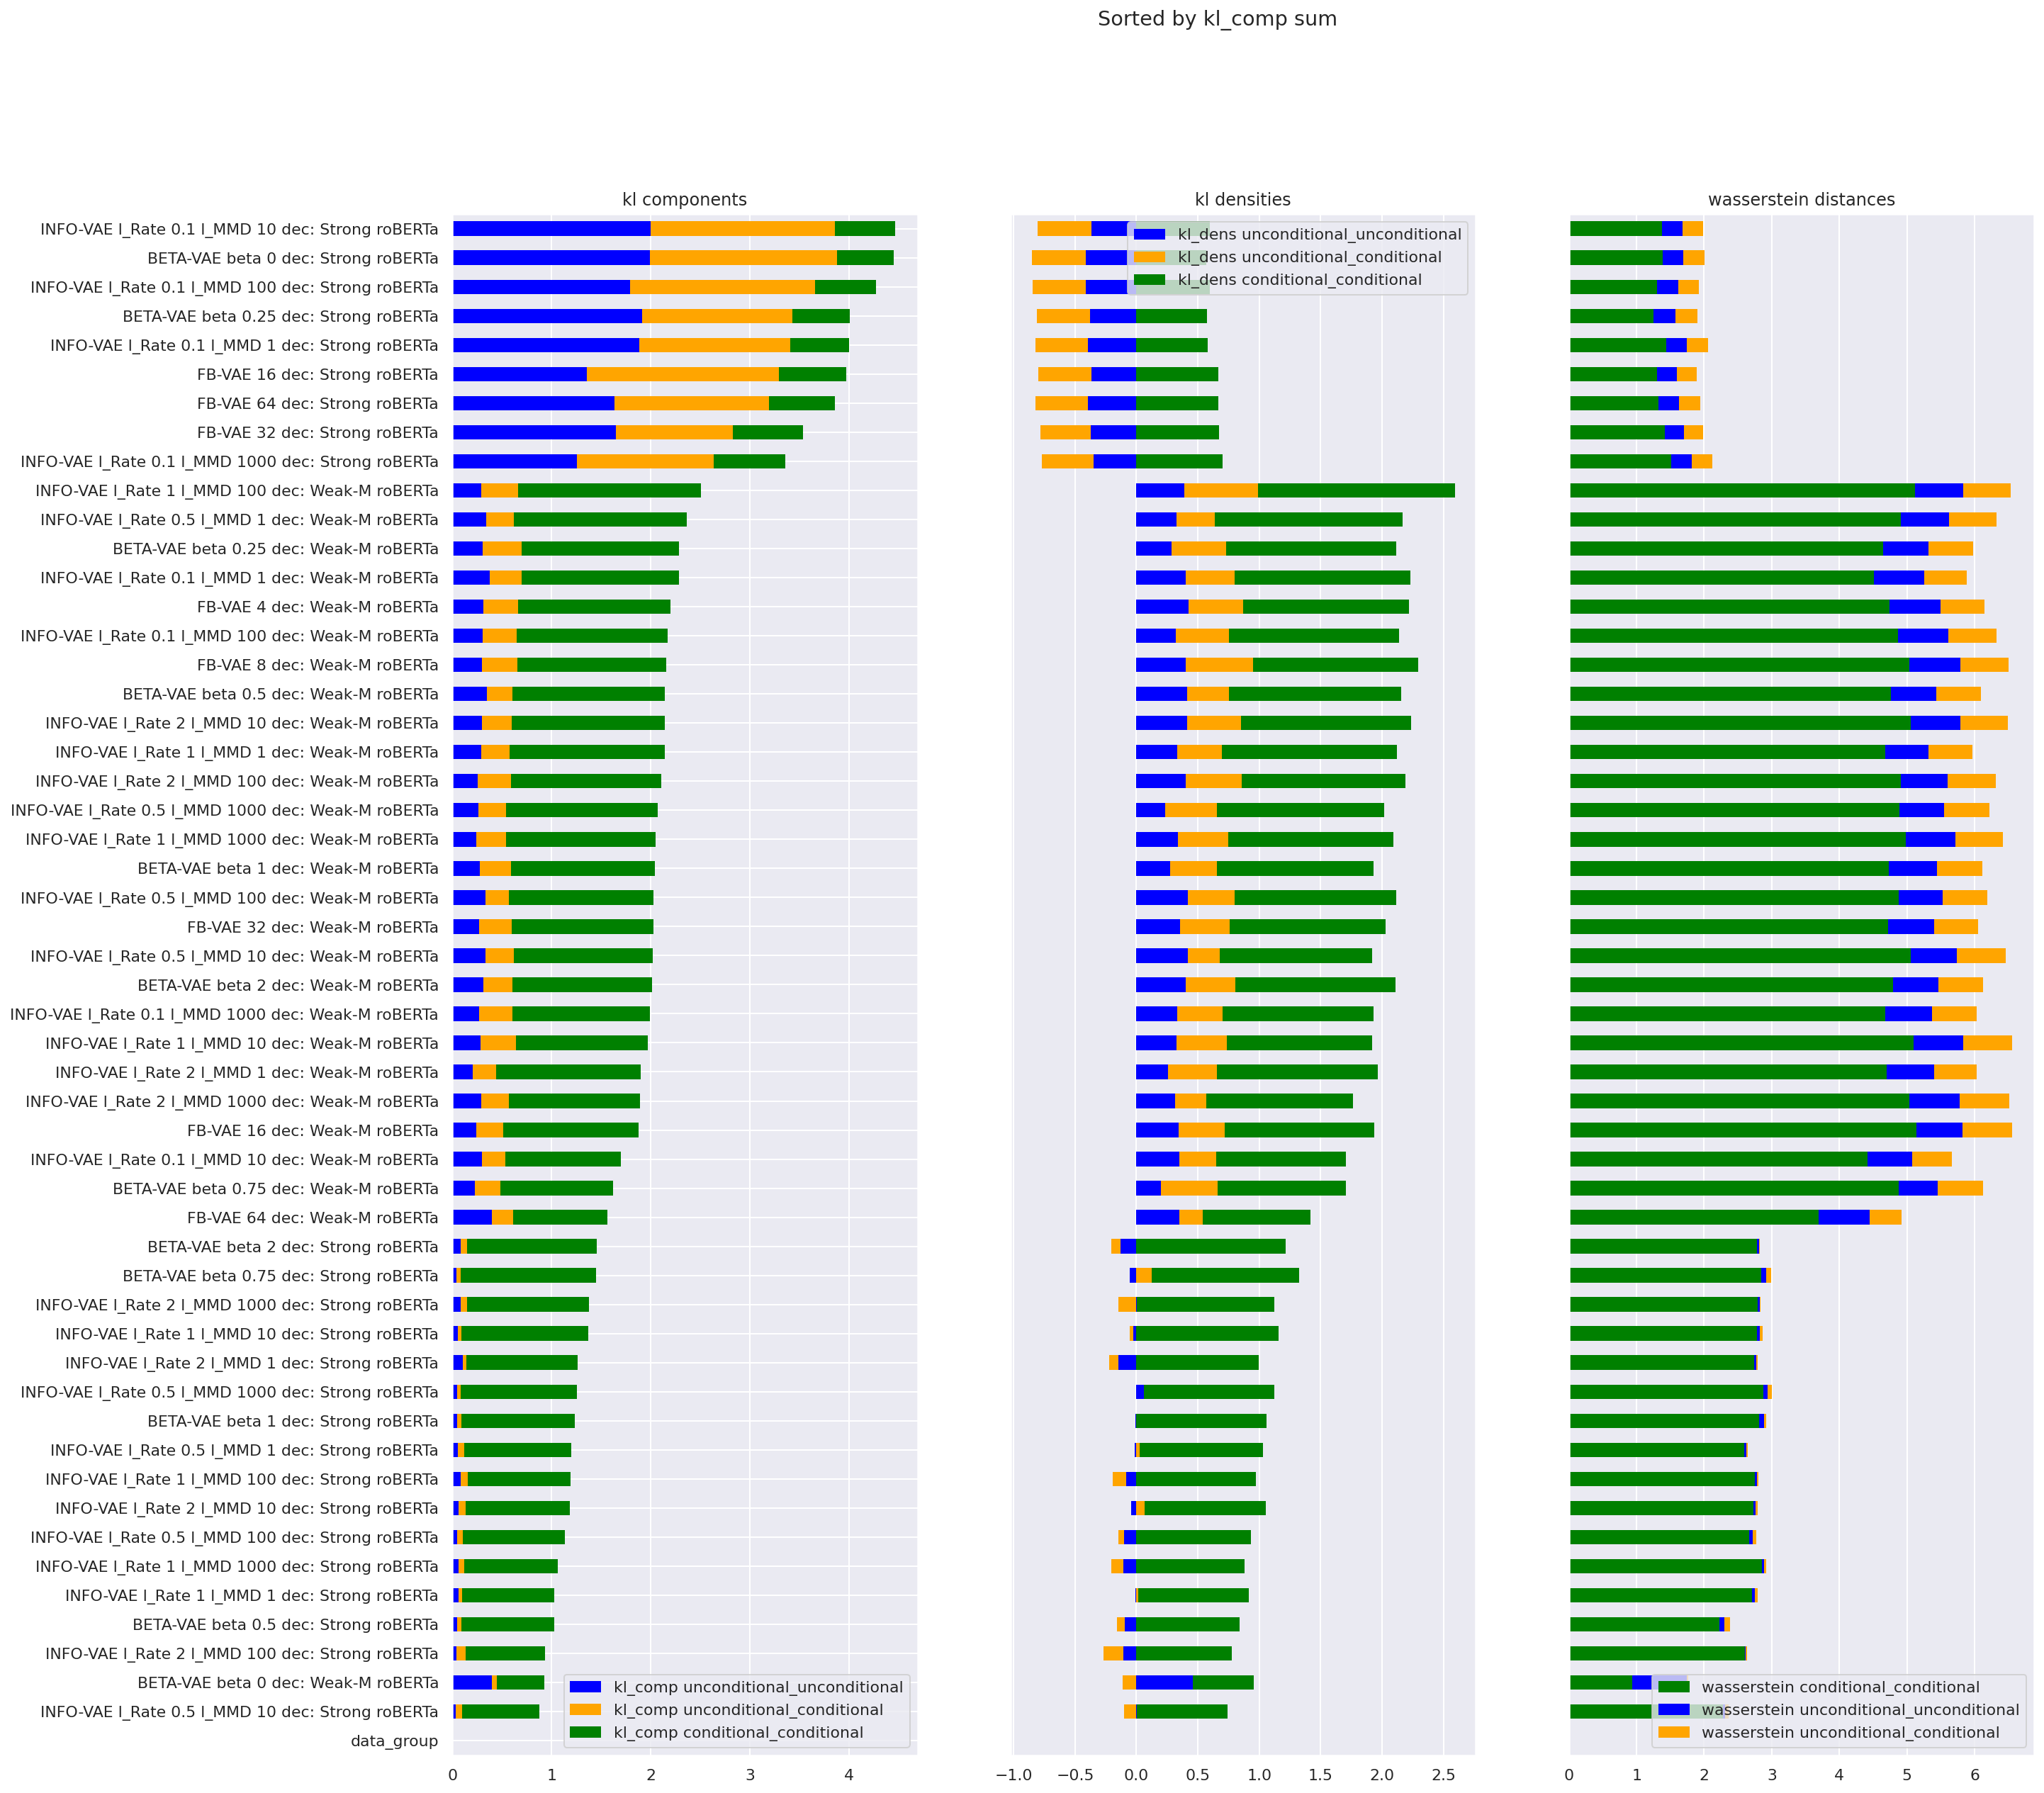

In [16]:
SORT_ON = "kl_comp sum"
plot_divergences_data_model_groups(all_df, sort_on=SORT_ON, plot_only=None)

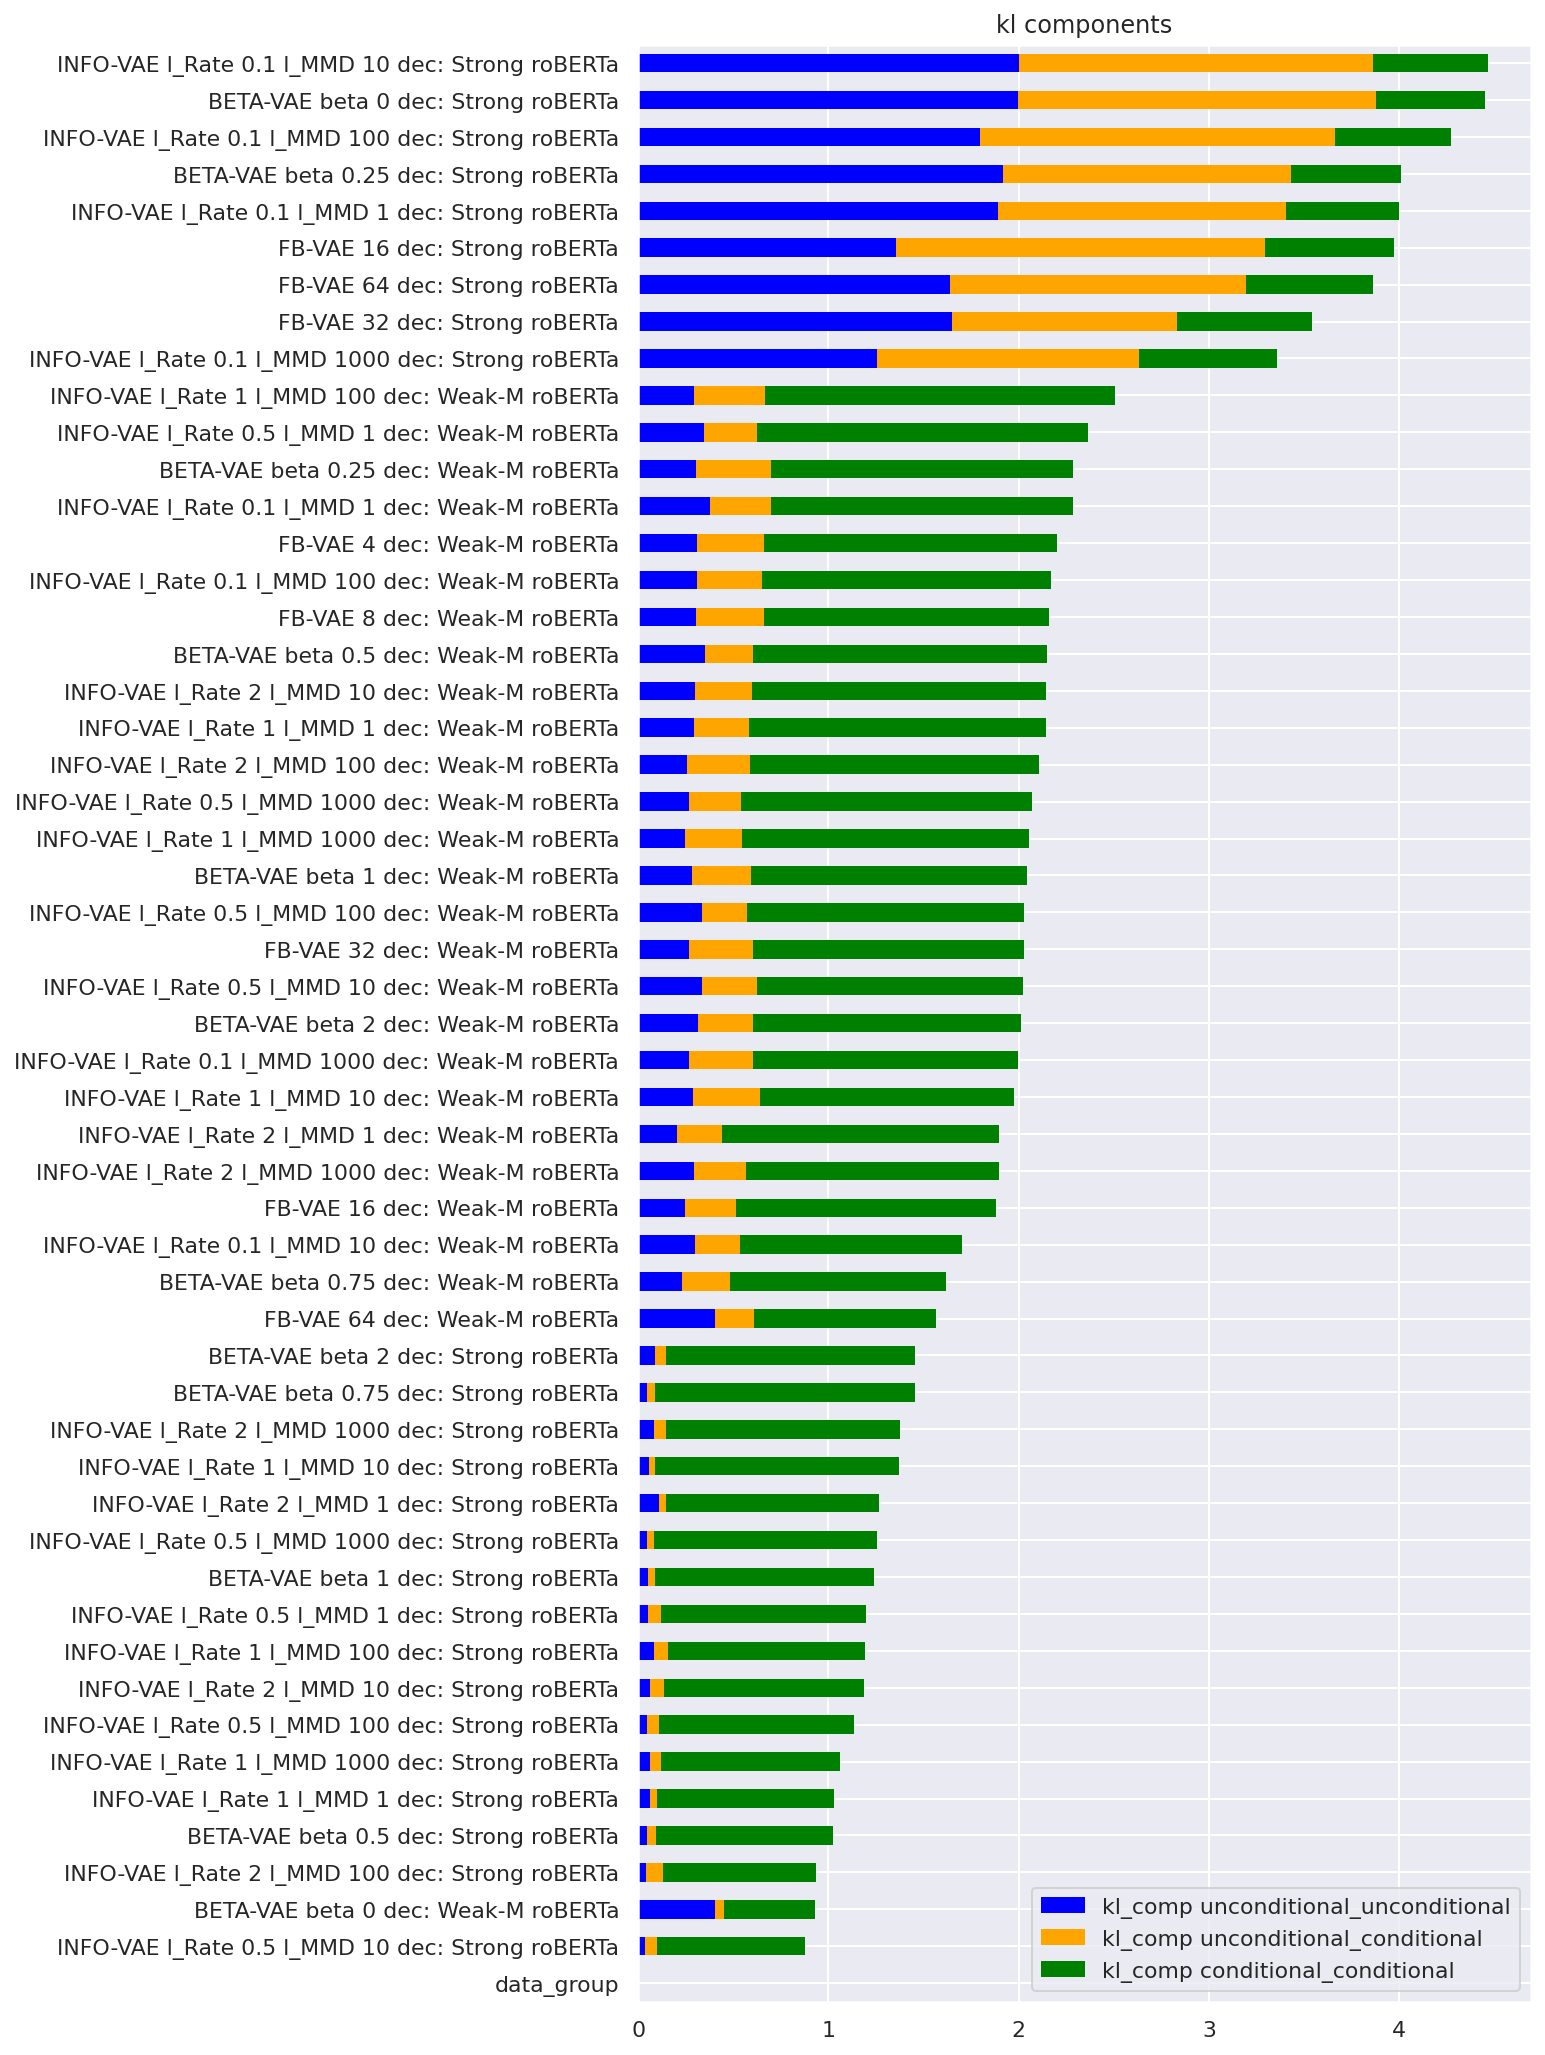

In [17]:
plot_divergences_data_model_groups(all_df, sort_on=SORT_ON, plot_only="kl_comp", figsize=(8, 18))

# Plot ordering against some global statistic

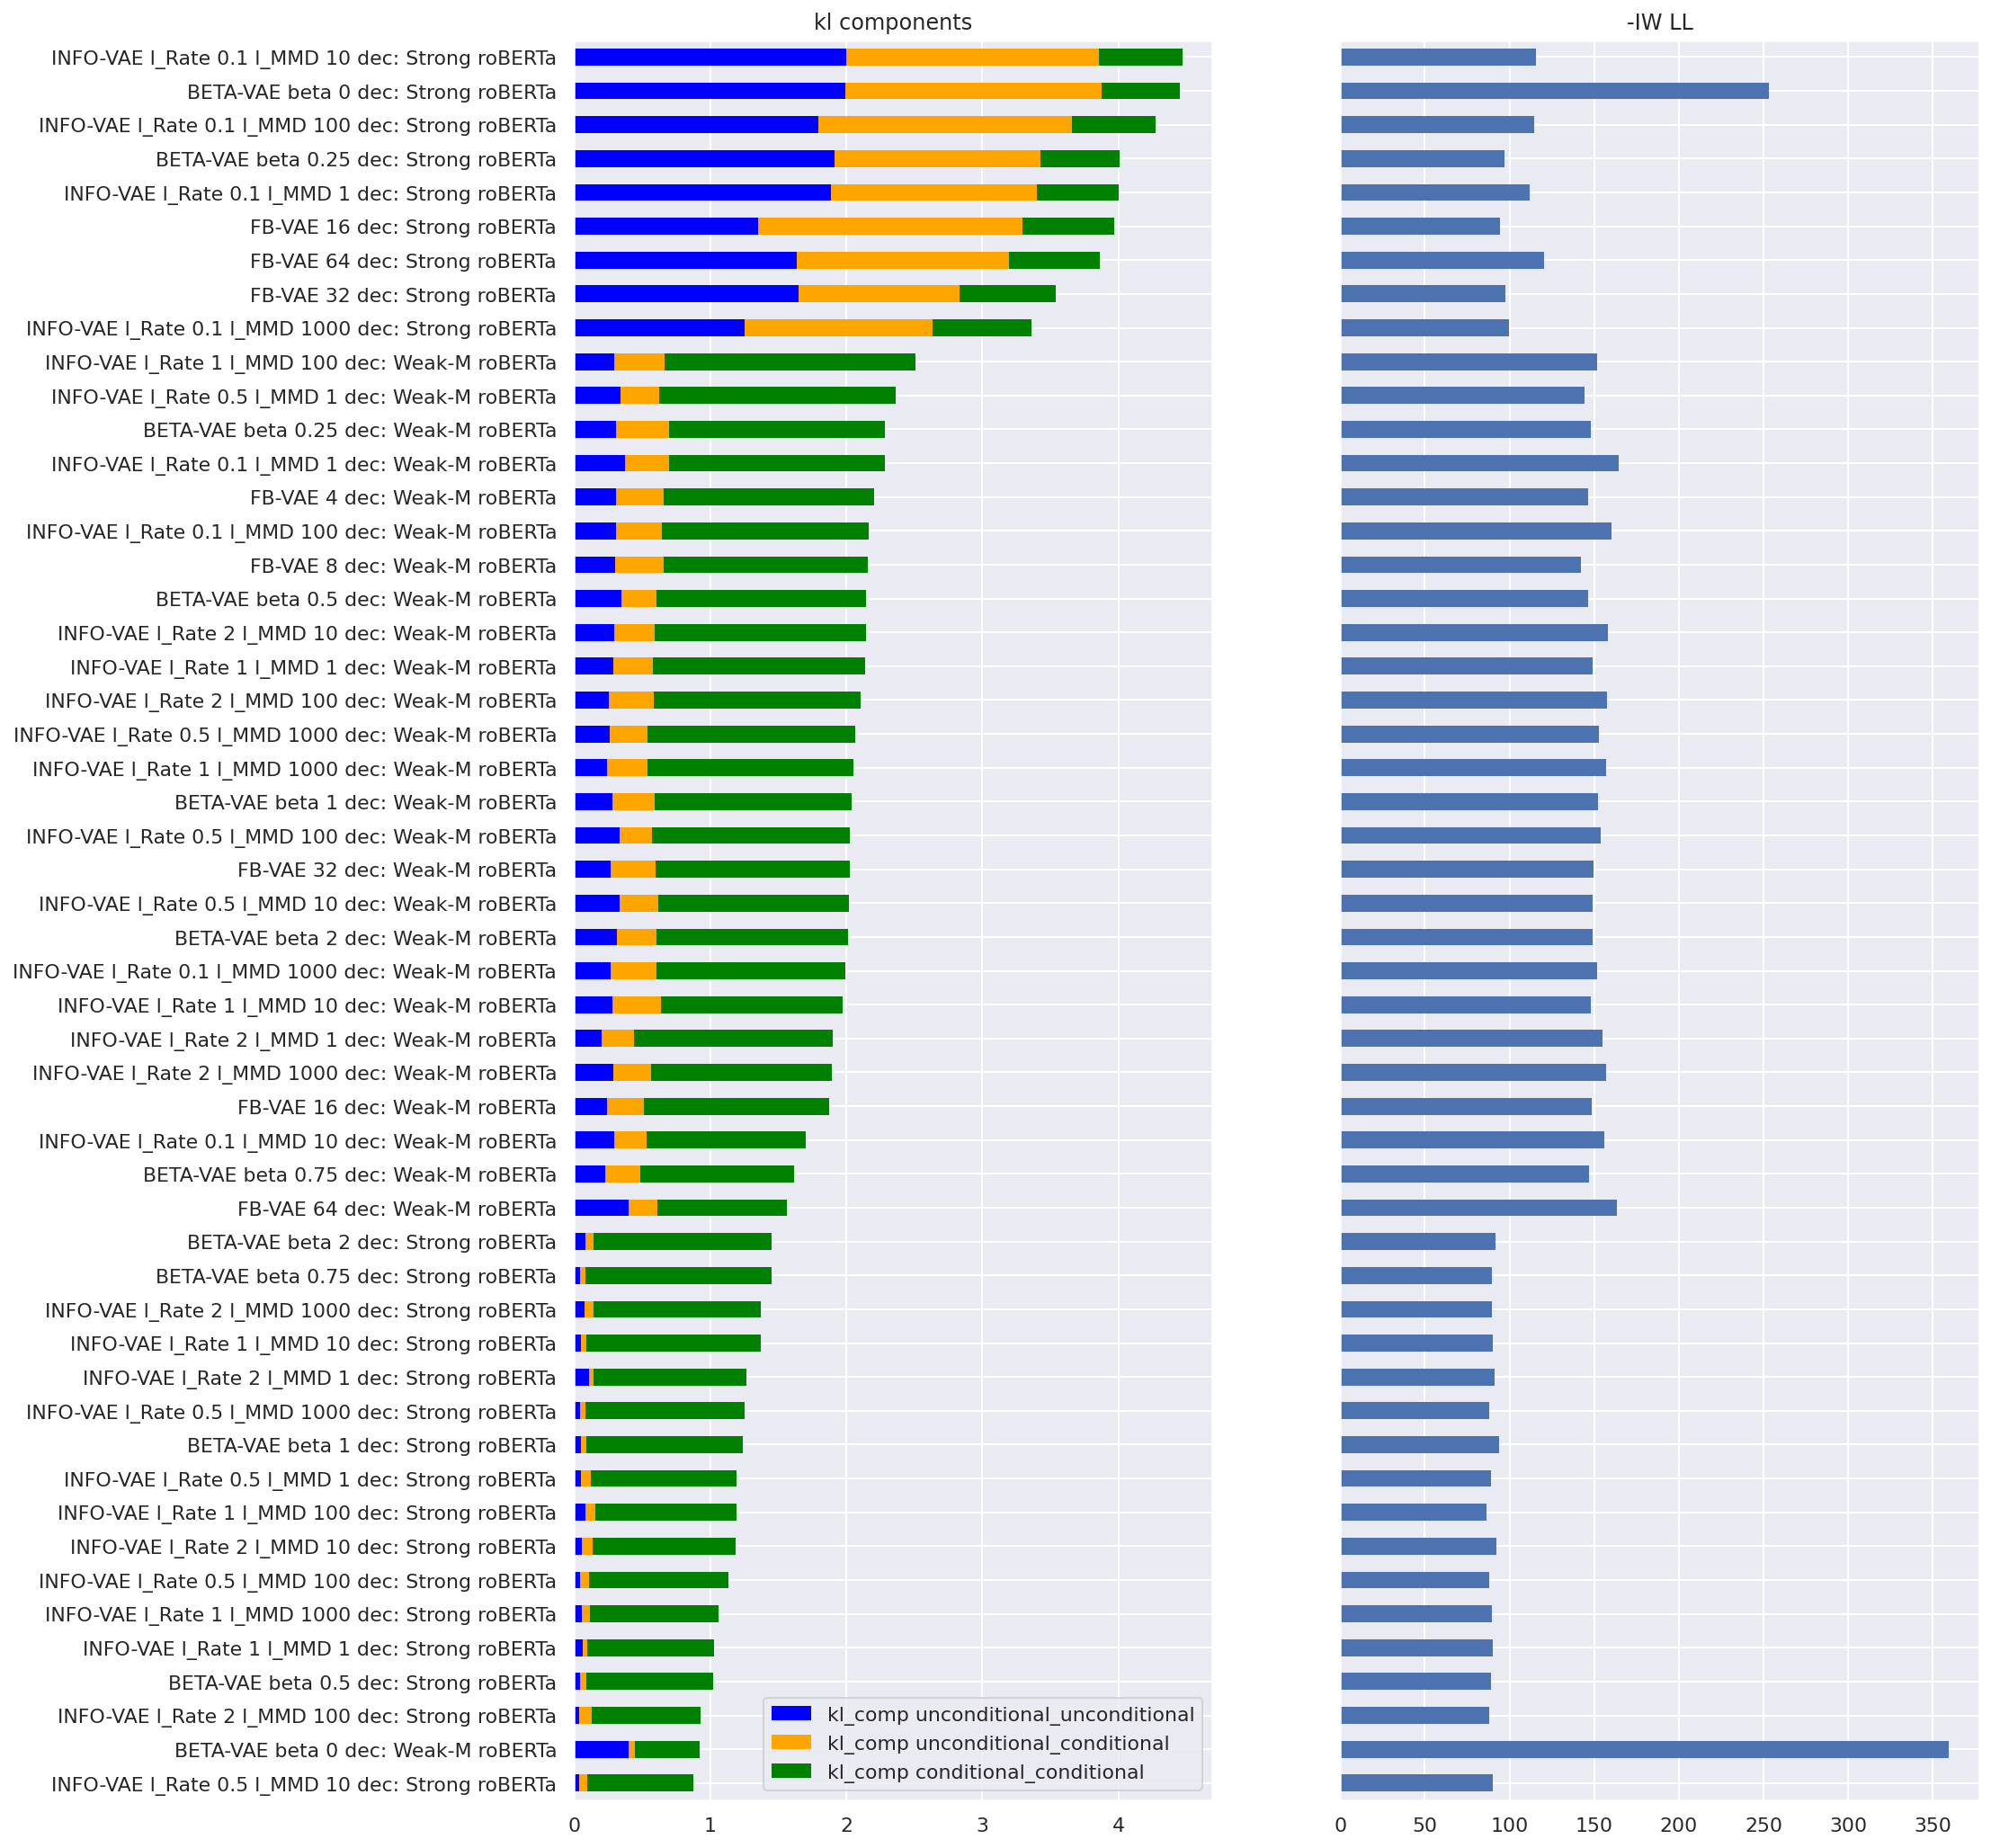

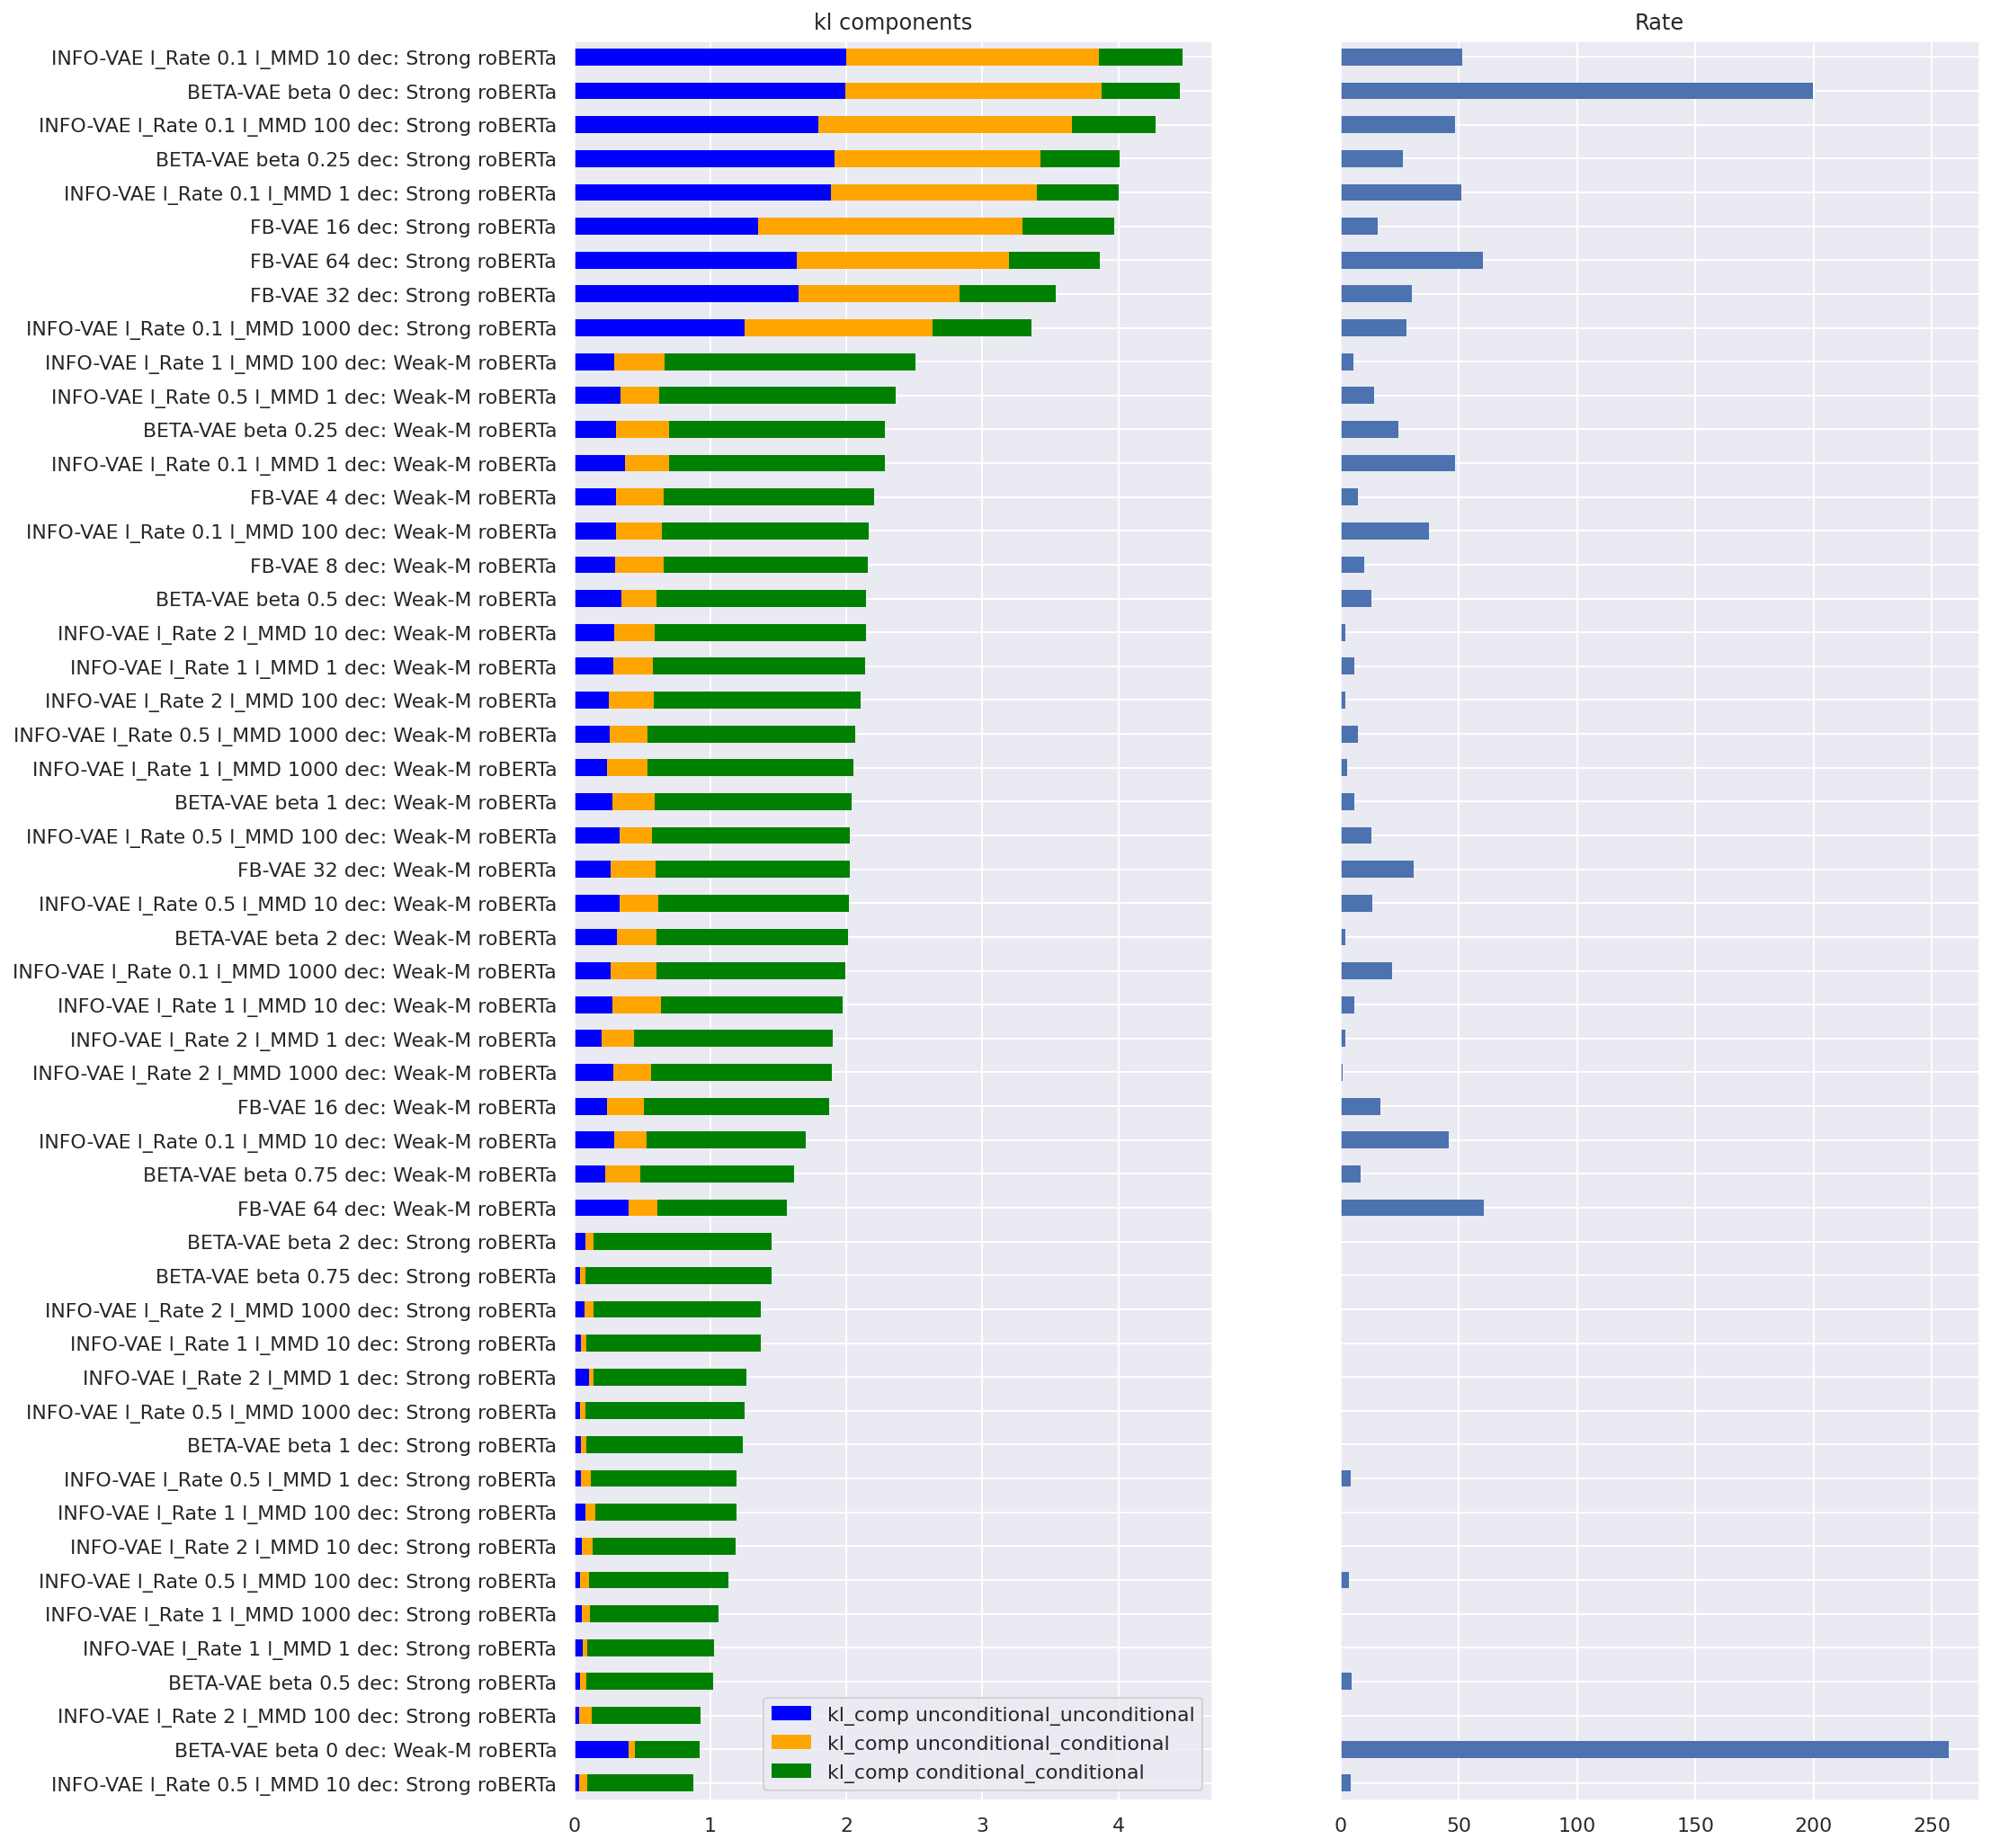

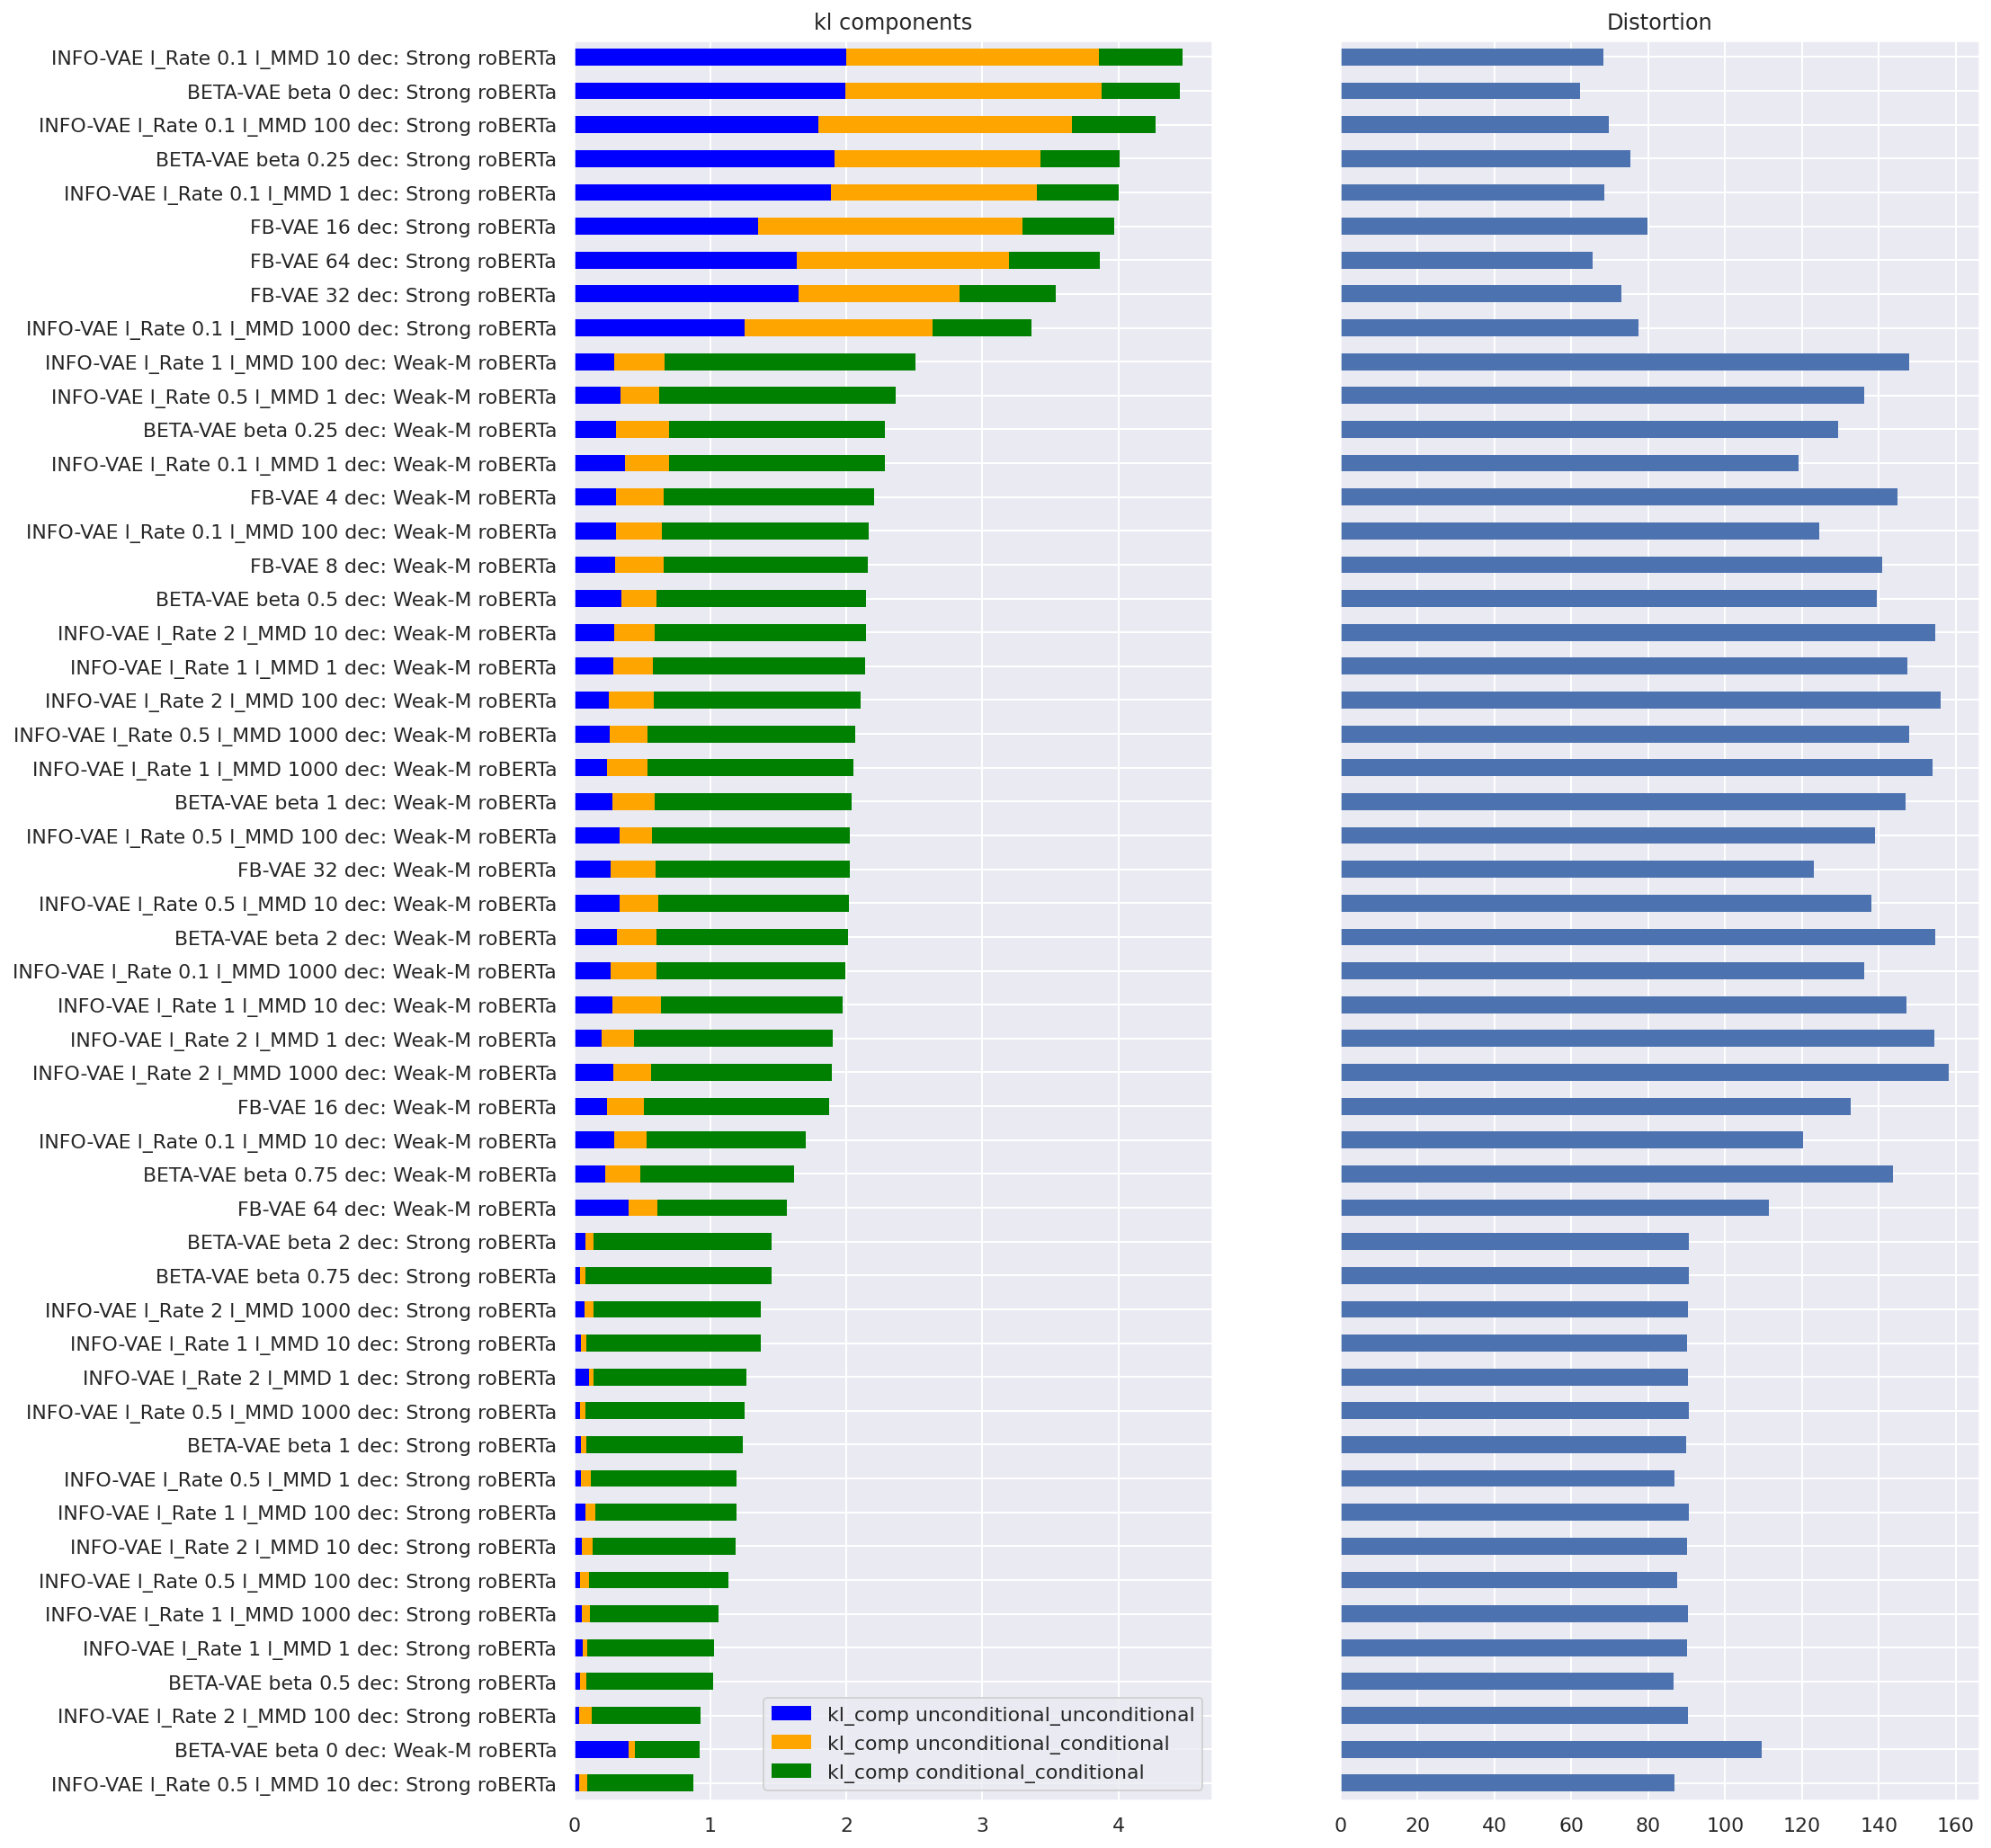

In [18]:
global_stats_df["-IW LL"] = - global_stats_df["IW LL"]

plot_divergences_data_model_groups_against_other_stat(all_df, global_stats_df, 
                                                      plot_against="-IW LL", plot_against_name="-IW LL", 
                                                      stat="kl_comp", figsize=(14, 18))

plot_divergences_data_model_groups_against_other_stat(all_df, global_stats_df, 
                                                      plot_against="kl_prior_post", plot_against_name="Rate", 
                                                      stat="kl_comp", figsize=(14, 18))

plot_divergences_data_model_groups_against_other_stat(all_df, global_stats_df, 
                                                      plot_against="distortion", plot_against_name="Distortion", 
                                                      stat="kl_comp", figsize=(14, 18))



# Old code

In [2]:
# toy_data_group_1 = np.concatenate([np.random.normal(loc=0.0, scale=10.0, size=(500,)),
#                                  np.random.normal(loc=10.0, scale=5.0, size=(300,)),
#                                  np.random.normal(loc=30, scale=10.0, size=(200,))])
# print(len(toy_data_group_1))
# toy_data_group_1 = toy_data_group_1[toy_data_group_1 > 2.0]
# print(len(toy_data_group_1))

# toy_data_group_2 = np.concatenate([np.random.normal(loc=50.0, scale=10.0, size=(500,)),
#                                  np.random.normal(loc=10.0, scale=5.0, size=(500,)),
#                                  np.random.normal(loc=5, scale=20.0, size=(100,))])
# print(len(toy_data_group_2))
# toy_data_group_2 = toy_data_group_2[toy_data_group_2 > 10.0]
# print(len(toy_data_group_2))

# toy_data_group_3 = np.concatenate([np.random.normal(loc=10.0, scale=5.0, size=(500,)),
#                                  np.random.normal(loc=0.0, scale=20.0, size=(100,)),
#                                  np.random.normal(loc=5, scale=20.0, size=(300,))])

# print(len(toy_data_group_3))
# toy_data_group_3 = toy_data_group_3[toy_data_group_3 > -5.0]
# print(len(toy_data_group_3))

# print(toy_data_group_1.shape)

# observations = [toy_data_group_1, toy_data_group_2, toy_data_group_3]
# group_names = ["data_group", "toy_data_group_2", "toy_data_group_3"]

# dp_mixture = DPMixture(
#             group_names, 
#             observations, 
#             obs_dist="normal", 
#             DP_alpha=1., 
#             num_comps=3, 
#             num_samples=1000, 
#             num_chains=1, 
#             num_warmup=100
#         )
        
# prior_samples = dp_mixture.draw_prior_predictions(num_samples=400)

# print(tabulate([(k, v.shape) for k, v in prior_samples.items()], headers=['rv', 'shape']))

# surprisal_dp_plot_checks(dp_mixture, prior_samples["y"], plot_max_groups=4)
# plot_model_data_preds_obs(dp_mixture, prior=True, num_prior_samples=400)
# # plot_all_groups_preds_obs(dp_mixture, prior=True, num_prior_samples=400)

In [ ]:
# class DPMixture:
#     def __init__(self, group_names: list, observations: list, obs_dist="normal",
#                  DP_alpha=1., num_comps=5, truncated_normal_low=0.0,
#                  num_samples=1000, num_chains=1, num_warmup=100):

#         self.DP_alpha = DP_alpha
#         self.T = num_comps

#         self.obs_dist = obs_dist
#         self.truncated_normal_low = truncated_normal_low

#         # [G]
#         self.group_names = group_names
#         self.G = len(group_names)

#         assert self.G > 1, "only data with more than one group is supported for now"

#         self.group_name_to_id = {n: i for i, n in enumerate(group_names)}
#         self.group_id_to_name = {i: n for i, n in enumerate(group_names)}

#         self.N = sum(len(y) for y in observations)

#         # [N]
#         self.obs_g = np.concatenate([[g] * len(y) for g, y in enumerate(observations)])
#         self.obs_y = np.concatenate(observations)

#         # print("obs g shape", self.obs_g.shape)
#         # print("obs y shape", self.obs_y.shape)

#         self.num_samples = num_samples
#         self.num_chains = num_chains
#         self.num_warmup = num_warmup

#         self.rng_key = random.PRNGKey(0)

#         nuts_kernel = NUTS(self.model)
#         self.mcmc = MCMC(nuts_kernel, num_samples=num_samples, num_warmup=num_warmup, num_chains=num_chains)

#         self.prior_predictive = None
#         self.posterior_predictive = None
#         self.posterior_samples = None

#     @classmethod
#     def mix_weights(cls, beta):
#         beta1m_cumprod = (1 - beta).cumprod(-1)
#         return jnp.pad(beta, ((0, 0), (0, 1)), constant_values=1) * jnp.pad(beta1m_cumprod, ((0, 0), (1, 0)),
#                                                                             constant_values=1)

#     @classmethod
#     def stick_break_sorting(cls, beta):
#         beta1m_cumprod = (1 - beta).cumprod(-1)
#         return jnp.pad(beta, (0, 1), constant_values=1) * jnp.pad(beta1m_cumprod, (1, 0), constant_values=1)

#     def model(self, y=None):
#         """
#         Pyro joint distribution.

#         Parameter:

#         y: observations as returned by self.prepare or None.
#             If None, the 'obs' node of the graphical model will be resampled.
#         """

#         N, G, T = self.N, self.G, self.T

#         loc, scale, df = 0.0, 0.0, 0.0

#         # Components
#         with numpyro.plate("components", T):
#             if self.obs_dist == "binomial":
#                 lamb = numpyro.sample("lamb", dist.Beta(1.0, 1.0))
#                 probs = numpyro.deterministic("probs", self.stick_break_sorting(lamb))

#                 # probs = numpyro.deterministic("probs", jnp.cumprod(lamb, axis=-1))
#                 # probs = numpyro.deterministic("probs", jnp.sort(lamb, axis=-1))
#                 # probs = jnp.sort(probs, axis=-1)

#             # loc & scale for log normal, normal and student T
#             elif "normal" in self.obs_dist or self.obs_dist == "student_t":
#                 if self.obs_dist == "log_normal":
#                     mean = 0.0
#                     std = 1.0
#                 else:
#                     mean = np.mean(self.obs_y)
#                     std = np.std(self.obs_y)
#                     print("mean:", mean, "std:", std)

#                 # [T]
#                 loc = numpyro.sample('loc', dist.Normal(mean, std))
#                 idx = jnp.argsort(loc, -1)  # , -1
#                 loc = loc[idx]

#                 # scale = numpyro.sample('scale', dist.Gamma(1, 10))
#                 scale = numpyro.sample('scale', dist.Uniform(0.1, std*5)) # was 20.0
#                 # scale = scale[idx]

#                 # degrees of freedom
#                 if self.obs_dist == "student_t":
#                     df = numpyro.sample("student_df", dist.Exponential(rate=1.0 / 10.0))
#                     # df = df[idx]

#             else:
#                 raise NotImplementedError

#         # Sample mixing weights
#         with numpyro.plate("DPs", G):
#             # [G, T-1]
#             beta = numpyro.sample("beta",
#                                   dist.Beta(np.ones(1), np.ones(1) * self.DP_alpha).expand((T - 1,)).to_event(1))

#         # [G, T]
#         omega = numpyro.deterministic("omega", self.mix_weights(beta))

#         loc_z, scale_z, df_z = 0.0, 0.0, 0.0
#         with numpyro.plate("observations", N):
#             # Choose component
#             z = numpyro.sample("z", dist.Categorical(probs=omega[self.obs_g]))

#             if "normal" in self.obs_dist or self.obs_dist == "student_t":
#                 loc_z = numpyro.deterministic("loc_z", loc[z])
#                 scale_z = numpyro.deterministic("scale_z", scale[z])

#                 if self.obs_dist == "student_t":
#                     df_z = numpyro.deterministic("df_z", df[z])

#             elif self.obs_dist == "binomial":
#                 probs_z = numpyro.deterministic("probs_z", probs[z])

#             # Construct the likelihood function
#             if self.obs_dist == "normal":
#                 sampled_y = numpyro.sample("y", dist.Normal(loc=loc_z, scale=scale_z), obs=y)

#             elif self.obs_dist == "log_normal":
#                 sampled_y = numpyro.sample("y", dist.LogNormal(loc=loc_z, scale=scale_z), obs=y)

#             elif self.obs_dist == "student_t":
#                 sampled_y = numpyro.sample("y", dist.StudentT(loc=loc_z, scale=scale_z, df=df_z), obs=y)

#             elif self.obs_dist == "binomial":
#                 sampled_y = numpyro.sample("y", dist.Binomial(probs=probs_z, total_count=28 * 28), obs=y)

#             elif self.obs_dist == "truncated_normal":
#                 sampled_y = numpyro.sample("y", dist.TruncatedNormal(low=self.truncated_normal_low,
#                                                                      loc=loc_z, scale=scale_z), obs=y)

#             else:
#                 raise NotImplementedError

#             # print("sampled y", sampled_y.shape)

#             return sampled_y

#     def run(self):
#         self.mcmc.run(self.rng_key, y=self.obs_y)
#         self.mcmc.print_summary()
#         self.posterior_samples = self.mcmc.get_samples(group_by_chain=False)
#         print("posterior samples shapes:")
#         for k, v in self.posterior_samples.items():
#             print(k, v.shape)

#     def make_prior_predictive(self, num_prior_samples=100):
#         if self.prior_predictive is None:
#             self.prior_predictive = Predictive(self.model, num_samples=num_prior_samples)

#     def draw_prior_predictions(self, num_samples=100):
#         if self.prior_predictive is None:
#             self.make_prior_predictive(num_prior_samples=num_samples)
#         rng_key, rng_key_ = random.split(self.rng_key)
#         return self.prior_predictive(rng_key_, y=None)

#     def make_posterior_predictive(self):
#         if self.posterior_samples is None:
#             raise RuntimeError("You need to run the sampler first")
#         if self.posterior_predictive is None:
#             self.posterior_predictive = Predictive(self.model, self.posterior_samples)

#     def draw_posterior_predictions(self, plot=False):
#         if self.posterior_predictive is None:
#             self.make_posterior_predictive()
#         rng_key, rng_key_ = random.split(self.rng_key)
#         return self.posterior_predictive(rng_key_, y=None)

In [44]:
# log_probs_ptb = dict()
# for k, v in surprisal_values.items():
#     log_probs_ptb[k] = dict()
#     for k1, v1 in v.items():
#         log_probs_ptb[k][k1] = -v1

# ptb_conditional = log_probs_ptb["data_group"]["conditional_conditional"]
# ptb_unconditional = log_probs_ptb["data_group"]["unconditional_unconditional"]

# c_dict = {
#     "data": "blue",
#     "model_uncon": "red",
#     "model_con": "orange",
#     "preds": "lightgreen"
# }

# dataset = "ptb"    
# N = len(surprisal_values) - 1 # minus data group

# nrows = N
# ncols = 3

# fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(3*ncols, 2*nrows), sharex="col")
# fig.set_facecolor("white")

# row = 0
# for model_name in log_probs_ptb.keys():

#     if model_name != "data_group":

#         preds = posterior_samples["y"][:, :2000]
             
#         # LENGTH PLOTS
#         sns.kdeplot(x=ptb_lengths["model_groups"][model_name]["conditional_sample"], 
#                     ax=axs[row, 0], label="model_con", color=c_dict["model_con"])

#         sns.kdeplot(x=ptb_lengths["model_groups"][model_name]["sample"], 
#                     ax=axs[row, 0], label="model_uncon", color=c_dict["model_uncon"])

#         sns.kdeplot(x=ptb_lengths["data_group"]["valid"], 
#                     ax=axs[row, 0], label="data", color=c_dict["data"])

#         sns.kdeplot(x=preds.flatten(), 
#                     ax=axs[row, 0], label="length model preds", color=c_dict["preds"])

#         axs[row, 0].set_title("Lengths")
#         axs[row, 0].legend(prop={"size":6})

#         # CONDITIONAL & UNCONDITIONAL LOG PROBS
#         # plot unconditional stistic for unconditional model samples
#         sns.kdeplot(x=log_probs_ptb[model_name]["unconditional_unconditional"], 
#                     ax=axs[row, 1], label="model unconditional", color=c_dict["model_uncon"])

#         # plot unconditional statistic for conditional model samples
#         sns.kdeplot(x=log_probs_ptb[model_name]["unconditional_conditional"], 
#                     ax=axs[row, 1], label="model conditional", color=c_dict["model_con"])

#         axs[row, 1].set_title(model_name + "\nunconditional log probs", y=1.02, size=10)

#         # plot conditional statistic for conditional model samples
#         sns.kdeplot(x=log_probs_ptb[model_name]["conditional_conditional"], 
#                     ax=axs[row, 2], label="model", color=c_dict["model_con"])
#         axs[row, 2].set_title("conditional log probs")

#         sns.kdeplot(x=ptb_conditional, 
#                         ax=axs[row, 2], label="data", color=c_dict["data"])
#         sns.kdeplot(x=ptb_unconditional, 
#                     ax=axs[row, 1], label="data", color=c_dict["data"])


#         axs[row, 1].legend(prop={"size":6})
#         axs[row, 2].legend(prop={"size":6})

#         axs[row, 2].set_ylim([0, 0.2])
#         axs[row, 2].set_xlim([-30, 10])

#         row += 1

# plt.tight_layout()
# plt.suptitle(dataset.upper(), y=1.01)
# plt.show()



In [17]:
# ptb_conditional = log_probs_ptb["data_group"]["conditional_conditional"]
# ptb_unconditional = log_probs_ptb["data_group"]["unconditional_unconditional"]

# # yahoo_answer_conditional = log_probs["yahoo_answer"]["data_group"]["conditional_conditional"]
# # yahoo_answer_unconditional = log_probs["yahoo_answer"]["data_group"]["unconditional_unconditional"]

# c_dict = {
#     "data": "blue",
#     "model_uncon": "red",
#     "model_con": "orange",
#     "preds": "lightgreen"
# }

# dataset = "ptb"    
# N = len(log_probs_ptb) - 1 # minus data group

# nrows = N
# ncols = 3

# fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(3*ncols, 2*nrows), sharex="col")
# fig.set_facecolor("white")

# row = 0
# for model_name in log_probs_ptb:

#     if model_name != "data_group":

#         preds = posterior_samples["y"][:, :2000]

#         # LENGTH PLOTS
#         sns.histplot(x=ptb_lengths["model_groups"][model_name]["valid_conditional"], 
#                     ax=axs[row, 0], label="model_con", color=c_dict["model_con"], alpha=0.4, bins=30, stat="density", )

#         sns.histplot(x=ptb_lengths["model_groups"][model_name]["unconditional"], 
#                     ax=axs[row, 0], label="model_uncon", color=c_dict["model_uncon"], alpha=0.4, bins=30, stat="density", )

#         sns.histplot(x=ptb_lengths["data_group"]["valid"], 
#                     ax=axs[row, 0], label="data", color=c_dict["data"], alpha=0.4, bins=30, stat="density", )

#         sns.histplot(x=preds.flatten(), 
#                     ax=axs[row, 0], label="length model preds", color=c_dict["preds"], alpha=0.4,bins=30,  stat="density")

#         axs[row, 0].set_title("Lengths")
#         axs[row, 0].legend(prop={"size":6})

#         # CONDITIONAL & UNCONDITIONAL LOG PROBS
#         # plot unconditional stistic for unconditional model samples
#         sns.histplot(x=log_probs_ptb[model_name]["unconditional_unconditional"], 
#                     ax=axs[row, 1], label="model unconditional", color=c_dict["model_uncon"],stat="density",bins=30,   alpha=0.4)

#         # plot unconditional statistic for conditional model samples
#         sns.histplot(x=log_probs_ptb[model_name]["unconditional_conditional"], 
#                     ax=axs[row, 1], label="model conditional", color=c_dict["model_con"], stat="density",bins=30,  alpha=0.4)

#         axs[row, 1].set_title(model_name + "\nunconditional log probs", y=1.02, size=10)

#         # plot conditional statistic for conditional model samples
#         sns.histplot(x=log_probs_ptb[model_name]["conditional_conditional"], 
#                     ax=axs[row, 2], label="model", color=c_dict["model_con"], stat="density",bins=30,  alpha=0.4)
#         axs[row, 2].set_title("conditional log probs")

#         sns.histplot(x=ptb_conditional, 
#                         ax=axs[row, 2], label="data", color=c_dict["data"], stat="density",bins=30,  alpha=0.4)
#         sns.histplot(x=ptb_unconditional, 
#                     ax=axs[row, 1], label="data", color=c_dict["data"], stat="density",bins=30,  alpha=0.4)


#         axs[row, 1].legend(prop={"size":6})
#         axs[row, 2].legend(prop={"size":6})

#         axs[row, 2].set_ylim([0, 0.5])
#         axs[row, 2].set_xlim([-30, 5])

#         row += 1

# plt.tight_layout()
# plt.suptitle(dataset.upper(), y=1.01)
# plt.show()



In [18]:
# fig, ax = plt.subplots(sharex=True, sharey=True, figsize=(10, 5))
# _ = ax.boxplot(posterior_samples['omega'][:,:].transpose())
# _ = ax.set_title(model.group_names[0])
# _ = ax.set_xlabel('k')
# _ = ax.set_ylabel(r'$\omega_{g,k}$')
# fig.tight_layout(h_pad=2, w_pad=2)

In [19]:
# This code does not work for a single group

# kls = []
# for g in range(model.G):
#     p = posterior_samples['omega'][:,0,:]
#     q = posterior_samples['omega'][:,g,:]
#     kls.append((p * (np.log(p) - np.log(q))).sum(-1))

# _ = plt.boxplot(kls[1:])
# _ = plt.ylabel(r'$E[KL(\omega_0||\omega_g)]$')
# _ = plt.xticks(np.arange(model.G - 1) + 1, model.group_names[1:]) 

In [20]:
# import scipy.stats as stats

# def plot_poisson_pmf(ax, rate, color, linestyle, num_points=100):
#     x = np.linspace(0, 4*rate, num_points)
#     return ax.plot(x, stats.norm.pdf(x, mu, sigma), color=color, linestyle=linestyle)

In [21]:
# posterior_samples["omega"].shape

In [22]:
# hatches = ['*', 'o', '/', '-']
# fig, ax = plt.subplots(model.T, 4, figsize=(15, 15))
# for t in range(model.T):
#     _ = ax[t, 0].hist(np.random.poisson(posterior_samples['rate'][:, t]), color='gray', bins='auto')
#     _ = ax[t, 0].set_xlabel(r'$L_{%d}$' % t)
    
#     _ = ax[t, 1].hist(posterior_samples['rate'][:, t], color='gray', bins='auto')
#     _ = ax[t, 1].set_xlabel(r'$\lambda_{%d}$' % t)
    
#     _ = ax[t, 2].boxplot([posterior_samples['omega'][:,t].transpose() for g in range(model.G)])
#     _ = ax[t, 2].set_xticklabels(model.group_names)
#     _ = ax[t, 2].set_ylabel(r'$\omega_{g,%d}$' % t)    
#     pal = cycle(sns.color_palette())
    
# #     for g in range(model.G):
#     _ = ax[t, 3].hist(posterior_samples['omega'][:,t], alpha=0.5, color=next(pal), hatch=hatches[0], bins=50, label=model.group_names[0] if t==0 else None)
#     _ = ax[t, 3].set_xlabel(r'$\omega_{g,%d}$' % t)

# fig.legend()    
# fig.tight_layout(h_pad=1, w_pad=1)

In [23]:
# def log_pdf(y, omega_g, rate):
#     # w_g: [S, T]    
#     # rate: [S, T]
#     # x: [S, N] ->[N, S] -> [N, S, T]
#     y = jnp.repeat(jnp.expand_dims(y, -1), omega_g.shape[-1], -1)
#     # [1, S, T] + [N, S, T] -> [N, S] -> [N]
#     return jnp.logaddexp(jnp.log(omega_g) + dist.Poisson(rate).log_prob(y), -1).mean(-1)

In [24]:
# def kl_estimate(x, a, b, num_predictive_samples, num_posterior_samples, samples):
#     S = samples['y'].shape[0]
    
#     idx1 = np.random.choice(S, size=num_posterior_samples)
#     #idx2 = np.random.choice(S, size=num_posterior_samples)
#     rate1 = samples['rate'][idx1]
#     rate2 = samples['rate'][idx1]
    
#     idx1 = np.random.choice(S, size=num_posterior_samples)
#     #idx2 = np.random.choice(S, size=num_posterior_samples)
#     omega_a = samples['omega'][idx1, a]
#     omega_b = samples['omega'][idx1, b]    

#     # [K]
#     idx_a = np.random.choice(len(x), p=(x==a)/(model.x==a).sum(-1), size=num_posterior_samples)
#     idx1 = np.random.choice(S, size=num_posterior_samples)    
#     y = samples['y'][idx1][np.arange(num_posterior_samples), idx_a]
    
#     print((log_pdf(y, omega_a, rate1)-log_pdf(y, omega_b, rate2)).mean())
# #     print(samples['y'][].shape)
#     # sample y from a given group a    
# #     log_pdf(y, omega_a, rate[idx1])
# #     log_pdf(y, omega_b, rate[idx2])

In [25]:
# kl_estimate(model.x, 0, 2, 30, 1000, posterior_samples)

In [26]:
# global_stats_df = pd.read_csv("/home/cbarkhof/fall-2021/analysis/global_stats.csv", index_col=0)
# global_stats_df.head()

In [ ]:
# global_stats_df = global_stats_df[(global_stats_df.index.isin(overview_df.index)) & (global_stats_df.phase == "valid")]

In [ ]:
# len(global_stats_df), len(overview_df)